In [ ]:
!pip install pydicom
!pip install SimpleITK

In [ ]:
import os
import pydicom
import numpy as np
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


TMTV for GT

In [ ]:
# import important libraries
import os
import glob
from tqdm import tqdm
import argparse
from numpy.random import seed
seed(1)

import nibabel as nib
import numpy as np
import csv

In [ ]:


# library for dmax computation
from skimage.measure import label,  regionprops
from skimage import data, util
from scipy.spatial import  distance

import pathlib

# from google.colab import drive
# drive.mount('/content/drive')

# function to write csv file
def write_to_csv_file(array, output_path, file_name="csv"):
    """
    :param array: array that consists rows and columns to be saved to csv file
    :param output_path: The directory to save csv file
    :param file_name: Name of the csv file
    :return: saved file_name.csv in the older output_path
    """
    array = np.array(array)
    file_name = str(output_path) + '/' + str(file_name) + '.csv'

    with open(file_name, 'w', newline='') as output:
        output_data = csv.writer(output, delimiter=",")
        for row in range(array.shape[0]):
            output_data.writerow(array[row][:])

    print("saved at: ", file_name)


# function to read .nii and compute biomarker values
def read_nii_mask_save_csv_tmtv_dmax(input_path, output_path):
    """
    :param input_path: Path to the directory that consists the directory for .nii files
    :param output_path:  The directory to save csv file, after computing the TMTV and Dmax, pixel spacing
    :return: read .nii, compute TMTV, Dmax
    """
    input_path = '/content/drive/MyDrive/' + input_path
    case_ids = os.listdir(input_path)
    print("Total number of cases to read: 0.1%d", len(case_ids))
    name_x_y_z_TMTV_dmax = [["ID", "X", "Y", "Z", 'TMTV', "Dmax"]]


    for n, case_name in tqdm(enumerate(case_ids), total=len(case_ids)):
        path_img_nii = str(input_path) + "/" + str(case_name)  # for GT worked
        print(path_img_nii)
        path_img_nii = glob.glob(path_img_nii + "/"+ str(case_name) +"_REF.nii.gz")[0] #for _REF _SEG



        try:
            # Read .nii files
            gt = nib.load(path_img_nii)
            res_pet = gt.header.get_zooms()
            gt = np.asanyarray(gt.dataobj)
            gt[gt > 0] = 1
            gt[gt <= 0] = 0

            # Compute TMTV
            def compute_TMTV(gt_):
                gt_[gt_ > 0] = 1
                gt_[gt_ <= 0] = 0
                return np.sum(gt_ > 0)

            #compute dmax
            def compute_dmax(gt_):
                # label images
                gt_ = util.img_as_ubyte(gt_) > 0
                gt_= label(gt_, connectivity=gt_.ndim)
                props = regionprops(gt_)

                dist_all = []
                for k in range(len(props)):
                    # physical space
                    a = np.multiply(np.array(props[k].centroid), np.array(res_pet))

                    # compute the distance between all other centroids:
                    if len(props) >1:
                        for kk in range(len(props)):
                            b = np.multiply(np.array(props[kk].centroid), np.array(res_pet))
                            dist = distance.euclidean(a, b)
                            dist_all.append(dist)
                    else:
                        dist_all.append(0)
                return np.max(dist_all)

            tmtv = compute_TMTV(gt.copy())
            dmax = compute_dmax(gt.copy())
            name_x_y_z_TMTV_dmax.append([str(case_name), res_pet[0], res_pet[1], res_pet[2],
                                         tmtv * res_pet[0] * res_pet[1] * res_pet[2], dmax])
        except:
            print(f"Error reading {path_img_nii}")
            continue

    write_to_csv_file(name_x_y_z_TMTV_dmax, output_path, file_name="data_xyz_tmtv_dmax_UW_REF_EJNMMI")#_SEG
    print('Total number of patients correctly read and their volume calculated: ', len(name_x_y_z_TMTV_dmax) - 1)
    print("Done !!")


if __name__ == "__main__":
    # We assume the .nii file name and the folder name are the same
    # parser = argparse.ArgumentParser(description="script to read nii files and compute TMTV and Dmax")
    # parser.add_argument("--input_dir", dest='input_dir',  type=pathlib.Path, help="Input directory path to .nii files")
    # parser.add_argument("--output_dir", dest='output_dir', type=pathlib.Path, help='output directory path')
    # args = parser.parse_args()

    # Update input_dir to point to the desired directory in your Google Drive
    input_dir = 'DLBCL_outcome_prediction/Tyler_lymphoma'  # Replace this with your desired directory
    output_dir='/content/drive/MyDrive/TMTV_Dmax_EJNMMI/'
    read_nii_mask_save_csv_tmtv_dmax(input_dir, output_dir)


Total number of cases to read: 0.1%d 79


  0%|          | 0/79 [00:00<?, ?it/s]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_073


  1%|▏         | 1/79 [00:02<02:38,  2.04s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_079


  3%|▎         | 2/79 [00:02<01:45,  1.37s/it]

Error reading /content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_079/UW_079_REF.nii.gz
/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_077


  4%|▍         | 3/79 [00:04<01:52,  1.48s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_080


  4%|▍         | 3/79 [00:04<02:03,  1.62s/it]


KeyboardInterrupt: ignored

In [ ]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd

def calculate_dice_score(gt_image, pred_image):
    gt_arr = sitk.GetArrayFromImage(gt_image)
    pred_arr = sitk.GetArrayFromImage(pred_image)
    intersection = np.logical_and(gt_arr, pred_arr).sum()
    dice = (2.0 * intersection) / (gt_arr.sum() + pred_arr.sum())
    return dice

def calculate_metrics(gt_image, pred_image):
    gt_arr = sitk.GetArrayFromImage(gt_image)
    pred_arr = sitk.GetArrayFromImage(pred_image)

    true_positive = np.logical_and(gt_arr, pred_arr).sum()
    false_positive = np.logical_and(np.logical_not(gt_arr), pred_arr).sum()
    false_negative = np.logical_and(gt_arr, np.logical_not(pred_arr)).sum()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    return precision, recall, false_positive, false_negative

results = []

input_path= 'DLBCL_outcome_prediction/Tyler_lymphoma'  #
output_dir='/content/drive/MyDrive/TMTV_Dmax_EJNMMI/'
input_path = '/content/drive/MyDrive/' + input_path
case_ids = os.listdir(input_path)

for n, case_name in tqdm(enumerate(case_ids), total=len(case_ids)):
    path_img_nii = str(input_path) + "/" + str(case_name)  # for GT worked
    pred_path = glob.glob(path_img_nii + "/"+ str(case_name) +"_SEG.nii.gz")[0] #for _REF _SEG
    gt_path = glob.glob(path_img_nii + "/"+ str(case_name) +"_REF.nii.gz")[0] #

    print(pred_path)

    gt_image = sitk.ReadImage(gt_path)
    pred_image = sitk.ReadImage(pred_path)

    # unique_gt=np.unique(gt_image)
    # print(unique_gt)
    # unique_pred=np.unique(pred_image)
    # print(unique_pred)
    #pred_image_new = np.where(pred_image  <= 6, pred_image, 0)

    threshold = 6
    gt_image_arr = sitk.GetArrayFromImage(gt_image)
    gt_image_arr_new = np.where((gt_image_arr <= threshold) & (gt_image_arr!=0 ), 1, 0)

# Create a new SimpleITK image from the thresholded array
    gt_image_new = sitk.GetImageFromArray(gt_image_arr_new)

# Set the origin, spacing, and direction of the new image
    gt_image_new.SetOrigin(gt_image.GetOrigin())
    gt_image_new.SetSpacing(gt_image.GetSpacing())
    gt_image_new.SetDirection(gt_image.GetDirection())

    dice = calculate_dice_score( gt_image_new, pred_image)
    precision, recall, false_positive, false_negative = calculate_metrics(gt_image_new, pred_image)

    results.append({
        "PatientID": case_name,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall,
        "FalsePositiveVolume": false_positive,
        "FalseNegativeVolume": false_negative
    })

# Convert results list to DataFrame and save to CSV
# results_df = pd.DataFrame(results)
# results_df.to_csv("metrics_results.csv", index=False)
results_df = pd.DataFrame(results)
write_to_csv_file(results_df, output_dir, file_name="metrics_results_UW_non_equrivocal_6")


  0%|          | 0/79 [00:00<?, ?it/s]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_073/UW_073_SEG.nii.gz


  1%|▏         | 1/79 [00:04<06:02,  4.65s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_079/UW_079_SEG.nii.gz


  3%|▎         | 2/79 [00:06<04:05,  3.19s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_077/UW_077_SEG.nii.gz


  4%|▍         | 3/79 [00:07<02:49,  2.23s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_080/UW_080_SEG.nii.gz


  5%|▌         | 4/79 [00:08<02:08,  1.72s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_078/UW_078_SEG.nii.gz


  6%|▋         | 5/79 [00:09<01:43,  1.40s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_081/UW_081_SEG.nii.gz


  8%|▊         | 6/79 [00:10<01:32,  1.27s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_075/UW_075_SEG.nii.gz


  9%|▉         | 7/79 [00:11<01:29,  1.24s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_072/UW_072_SEG.nii.gz


 10%|█         | 8/79 [00:12<01:17,  1.09s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_076/UW_076_SEG.nii.gz


 11%|█▏        | 9/79 [00:13<01:18,  1.13s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_074/UW_074_SEG.nii.gz


 13%|█▎        | 10/79 [00:14<01:12,  1.06s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_068/UW_068_SEG.nii.gz


 14%|█▍        | 11/79 [00:15<01:13,  1.08s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_063/UW_063_SEG.nii.gz


 15%|█▌        | 12/79 [00:16<01:11,  1.06s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_071/UW_071_SEG.nii.gz


 16%|█▋        | 13/79 [00:17<01:08,  1.03s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_066/UW_066_SEG.nii.gz


 18%|█▊        | 14/79 [00:19<01:14,  1.14s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_067/UW_067_SEG.nii.gz


 19%|█▉        | 15/79 [00:20<01:24,  1.32s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_065/UW_065_SEG.nii.gz


 20%|██        | 16/79 [00:21<01:12,  1.16s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_062/UW_062_SEG.nii.gz


 22%|██▏       | 17/79 [00:22<01:06,  1.08s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_069/UW_069_SEG.nii.gz


 23%|██▎       | 18/79 [00:23<01:07,  1.11s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_064/UW_064_SEG.nii.gz


 24%|██▍       | 19/79 [00:24<01:05,  1.09s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_070/UW_070_SEG.nii.gz


 25%|██▌       | 20/79 [00:25<01:02,  1.05s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_053/UW_053_SEG.nii.gz


 27%|██▋       | 21/79 [00:26<01:00,  1.04s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_052/UW_052_SEG.nii.gz


 28%|██▊       | 22/79 [00:27<00:57,  1.00s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_057/UW_057_SEG.nii.gz


 29%|██▉       | 23/79 [00:28<00:57,  1.03s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_061/UW_061_SEG.nii.gz


 30%|███       | 24/79 [00:30<00:59,  1.08s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_054/UW_054_SEG.nii.gz


 32%|███▏      | 25/79 [00:31<00:59,  1.10s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_058/UW_058_SEG.nii.gz


 33%|███▎      | 26/79 [00:32<00:59,  1.13s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_056/UW_056_SEG.nii.gz


 34%|███▍      | 27/79 [00:34<01:07,  1.30s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_060/UW_060_SEG.nii.gz


 35%|███▌      | 28/79 [00:34<00:59,  1.17s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_059/UW_059_SEG.nii.gz


 37%|███▋      | 29/79 [00:36<00:57,  1.14s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_055/UW_055_SEG.nii.gz


<ipython-input-66-b029efd64d20>:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positive / (true_positive + false_positive)
 38%|███▊      | 30/79 [00:36<00:52,  1.08s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_049/UW_049_SEG.nii.gz


 39%|███▉      | 31/79 [00:37<00:48,  1.02s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_043/UW_043_SEG.nii.gz


 41%|████      | 32/79 [00:38<00:48,  1.04s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_051/UW_051_SEG.nii.gz


 42%|████▏     | 33/79 [00:39<00:46,  1.02s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_046/UW_046_SEG.nii.gz


 43%|████▎     | 34/79 [00:40<00:44,  1.02it/s]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_047/UW_047_SEG.nii.gz


 44%|████▍     | 35/79 [00:41<00:43,  1.00it/s]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_048/UW_048_SEG.nii.gz


 46%|████▌     | 36/79 [00:42<00:40,  1.06it/s]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_044/UW_044_SEG.nii.gz


 47%|████▋     | 37/79 [00:43<00:39,  1.06it/s]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_050/UW_050_SEG.nii.gz


 48%|████▊     | 38/79 [00:44<00:42,  1.04s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_042/UW_042_SEG.nii.gz


 49%|████▉     | 39/79 [00:45<00:39,  1.02it/s]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_045/UW_045_SEG.nii.gz


 51%|█████     | 40/79 [00:46<00:40,  1.04s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_032/UW_032_SEG.nii.gz


 52%|█████▏    | 41/79 [00:47<00:36,  1.05it/s]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_033/UW_033_SEG.nii.gz


 53%|█████▎    | 42/79 [00:49<00:41,  1.11s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_040/UW_040_SEG.nii.gz


 54%|█████▍    | 43/79 [00:50<00:39,  1.11s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_034/UW_034_SEG.nii.gz


 56%|█████▌    | 44/79 [00:51<00:42,  1.20s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_038/UW_038_SEG.nii.gz


 57%|█████▋    | 45/79 [00:52<00:39,  1.16s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_041/UW_041_SEG.nii.gz


 58%|█████▊    | 46/79 [00:53<00:33,  1.02s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_035/UW_035_SEG.nii.gz


 59%|█████▉    | 47/79 [00:54<00:34,  1.09s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_039/UW_039_SEG.nii.gz


 61%|██████    | 48/79 [00:55<00:32,  1.06s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_036/UW_036_SEG.nii.gz


<ipython-input-66-b029efd64d20>:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positive / (true_positive + false_positive)
 62%|██████▏   | 49/79 [00:56<00:32,  1.09s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_037/UW_037_SEG.nii.gz


 63%|██████▎   | 50/79 [00:58<00:32,  1.13s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_028/UW_028_SEG.nii.gz


 65%|██████▍   | 51/79 [00:59<00:31,  1.14s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_030/UW_030_SEG.nii.gz


 66%|██████▌   | 52/79 [01:00<00:35,  1.30s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_025/UW_025_SEG.nii.gz


<ipython-input-66-b029efd64d20>:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positive / (true_positive + false_positive)
 67%|██████▋   | 53/79 [01:02<00:33,  1.28s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_031/UW_031_SEG.nii.gz


 68%|██████▊   | 54/79 [01:03<00:30,  1.23s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_026/UW_026_SEG.nii.gz


 70%|██████▉   | 55/79 [01:04<00:30,  1.26s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_027/UW_027_SEG.nii.gz


 71%|███████   | 56/79 [01:05<00:29,  1.29s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_023/UW_023_SEG.nii.gz


 72%|███████▏  | 57/79 [01:06<00:24,  1.13s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_022/UW_022_SEG.nii.gz


 73%|███████▎  | 58/79 [01:08<00:25,  1.20s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_016/UW_016_SEG.nii.gz


 75%|███████▍  | 59/79 [01:08<00:21,  1.07s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_020/UW_020_SEG.nii.gz


 76%|███████▌  | 60/79 [01:09<00:19,  1.04s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_019/UW_019_SEG.nii.gz


 77%|███████▋  | 61/79 [01:10<00:19,  1.09s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_015/UW_015_SEG.nii.gz


 78%|███████▊  | 62/79 [01:11<00:16,  1.01it/s]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_014/UW_014_SEG.nii.gz


 80%|███████▉  | 63/79 [01:12<00:15,  1.02it/s]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_018/UW_018_SEG.nii.gz


 81%|████████  | 64/79 [01:13<00:15,  1.03s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_013/UW_013_SEG.nii.gz


 82%|████████▏ | 65/79 [01:14<00:13,  1.00it/s]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_017/UW_017_SEG.nii.gz


 84%|████████▎ | 66/79 [01:16<00:15,  1.18s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_012/UW_012_SEG.nii.gz


 85%|████████▍ | 67/79 [01:17<00:15,  1.32s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_021/UW_021_SEG.nii.gz


 86%|████████▌ | 68/79 [01:18<00:12,  1.15s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_005/UW_005_SEG.nii.gz


 87%|████████▋ | 69/79 [01:20<00:13,  1.31s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_009/UW_009_SEG.nii.gz


 89%|████████▊ | 70/79 [01:21<00:12,  1.34s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_007/UW_007_SEG.nii.gz


 90%|████████▉ | 71/79 [01:22<00:09,  1.25s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_002/UW_002_SEG.nii.gz


 91%|█████████ | 72/79 [01:23<00:08,  1.18s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_008/UW_008_SEG.nii.gz


 92%|█████████▏| 73/79 [01:24<00:06,  1.06s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_003/UW_003_SEG.nii.gz


 94%|█████████▎| 74/79 [01:25<00:05,  1.10s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_006/UW_006_SEG.nii.gz


 95%|█████████▍| 75/79 [01:26<00:04,  1.00s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_010/UW_010_SEG.nii.gz


 96%|█████████▌| 76/79 [01:27<00:03,  1.05s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_004/UW_004_SEG.nii.gz


<ipython-input-66-b029efd64d20>:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positive / (true_positive + false_positive)
 97%|█████████▋| 77/79 [01:28<00:02,  1.09s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_011/UW_011_SEG.nii.gz


 99%|█████████▊| 78/79 [01:30<00:01,  1.07s/it]

/content/drive/MyDrive/DLBCL_outcome_prediction/Tyler_lymphoma/UW_001/UW_001_SEG.nii.gz


100%|██████████| 79/79 [01:31<00:00,  1.15s/it]

saved at:  /content/drive/MyDrive/TMTV_Dmax_EJNMMI//metrics_results_UW_non_equrivocal_6.csv


In [ ]:
# def write_to_csv_file(array, output_path, file_name="csv"):
#     """
#     :param array: array that consists rows and columns to be saved to csv file
#     :param output_path: The directory to save csv file
#     :param file_name: Name of the csv file
#     :return: saved file_name.csv in the older output_path
#     """
#     array = np.array(array)
#     file_name = str(output_path) + '/' + str(file_name) + '.csv'

#     with open(file_name, 'w', newline='') as output:
#         output_data = csv.writer(output, delimiter=",")
#         for row in range(array.shape[0]):
#             output_data.writerow(array[row][:])

#     print("saved at: ", file_name)
# write_to_csv_file(results_df, output_dir, file_name="metrics_results_UW_non_equrivocal")


saved at:  /content/drive/MyDrive/TMTV_Dmax_EJNMMI//metrics_results_UW_non_equrivocal.csv


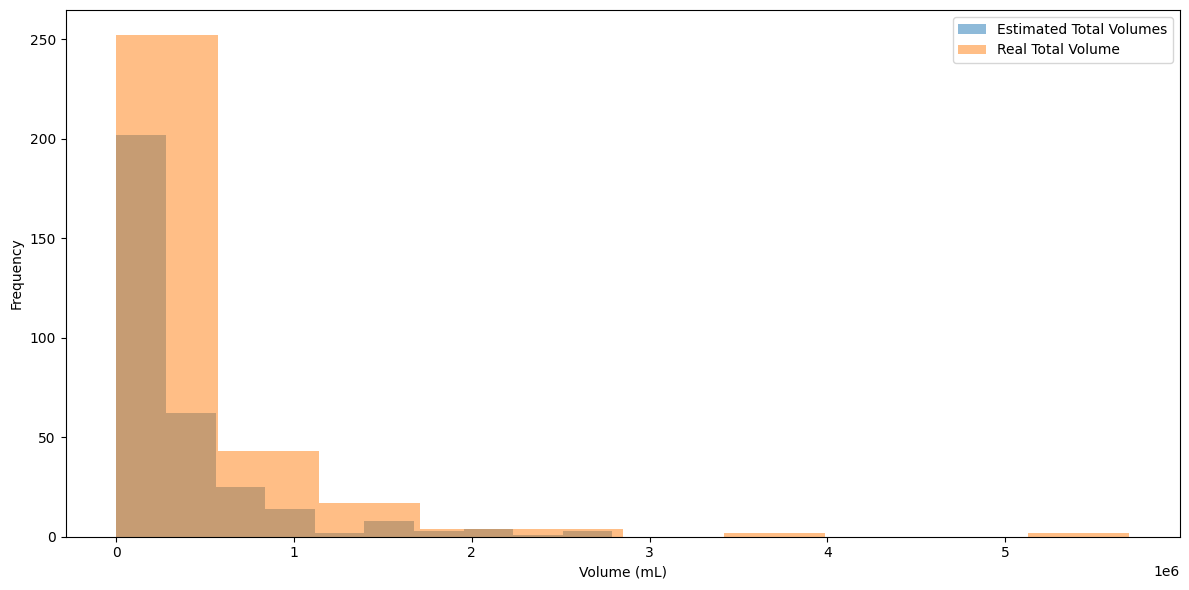

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all.xlsx'
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'#'TMTV_all_center_type_info.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate error
df['Error'] = abs((df['Predicted']/1000) - (df['GT']/10000))

# Sample estimated volumes and real volume (replace with your data)
estimated_volumes = df['Predicted']#np.array([100, 105, 98, 102, 110])##
real_volume = df['GT']

# Calculate Bias
bias = np.mean(estimated_volumes) - real_volume

# Calculate Noise (Standard Deviation)
noise = np.std(estimated_volumes)

# Calculate Coefficient of Variation (Variability)
coefficient_of_variation = (noise / np.mean(estimated_volumes)) * 100

# Calculate Percent Error for each estimated volume
percent_errors = np.abs((estimated_volumes - real_volume) / real_volume) * 100

# Calculate Mean and Standard Deviation of Percent Errors
mean_percent_error = np.mean(percent_errors)
std_percent_error = np.std(percent_errors)

# Visualization
plt.figure(figsize=(12, 6))
# plt.subplot(2, 2, 1)
plt.hist(estimated_volumes, bins=10, alpha=0.5, label='Estimated Total Volumes')
#plt.axvline(x=real_volume, color='red', linestyle='--', label='Real Volume')
plt.hist(real_volume , bins=10, alpha=0.5, label='Real Total Volume')
plt.xlabel('Volume (mL)')
plt.ylabel('Frequency')
plt.legend()

# plt.subplot(2, 2, 2)
# plt.boxplot(estimated_volumes)
# plt.xticks([1], ['Estimated Total Volumes'])
# plt.ylabel('Volume')

# plt.subplot(2, 2, 3)
# plt.hist(percent_errors, bins=10, alpha=0.5, label='Percent Errors')
# plt.xlabel('Percent Error (%)')
# plt.ylabel('Frequency')

# plt.subplot(2, 2, 4)
# plt.bar(['Mean', 'Std'], [mean_percent_error, std_percent_error], alpha=0.5)
# plt.ylabel('Percent Error (%)')

plt.tight_layout()
plt.show()

# # Print Results
# print(f'Bias: {bias}')
# print(f'Noise (Standard Deviation): {noise}')
# print(f'Coefficient of Variation (Variability): {coefficient_of_variation}%')
# print(f'Mean Percent Error: {mean_percent_error}%')
# print(f'Standard Deviation of Percent Error: {std_percent_error}%')


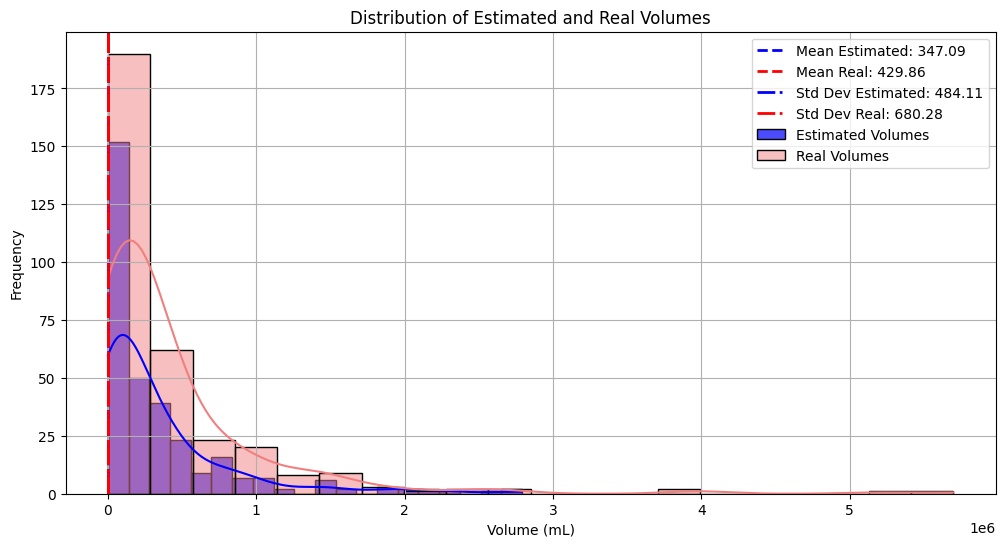

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all.xlsx'
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'#'TMTV_all_center_type_info.xlsx'
#file_path = 'Noise_Bias_no_outlier_code.xlsx'
# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate error
df['Error'] = abs((df['Predicted'] / 1000) - (df['GT'] / 1000))

# Sample estimated volumes and real volume (replace with your data)
estimated_volumes = df['Predicted'] /1000 # np.array([100, 105, 98, 102, 110])##
real_volume = df['GT']/1000

# Calculate error
# df['Error'] = abs((df['Predicted'] ) - (df['GT'] ))

# # Sample estimated volumes and real volume (replace with your data)
# estimated_volumes = df['Predicted']  # np.array([100, 105, 98, 102, 110])##
# real_volume = df['GT']
# Calculate Bias
bias = np.mean(estimated_volumes) - real_volume

# Calculate Noise (Standard Deviation)
noise = np.std(estimated_volumes)

# Calculate Coefficient of Variation (Variability)
coefficient_of_variation = (noise / np.mean(estimated_volumes)) * 100

# Calculate Percent Error for each estimated volume
percent_errors = np.abs((estimated_volumes - real_volume) / real_volume) * 100

# Calculate Mean and Standard Deviation of Percent Errors
mean_percent_error = np.mean(percent_errors)
std_percent_error = np.std(percent_errors)

# Visualization
plt.figure(figsize=(12, 6))

# Plot Estimated and Real Volumes as histograms

sns.histplot(data=df, x='Predicted', bins=20, color='blue', alpha=0.7, label='Estimated Volumes', kde=True)
sns.histplot(data=df, x='GT', bins=20, color='lightcoral', alpha=0.5, label='Real Volumes', kde=True)
plt.xlabel('Volume (mL)')
plt.ylabel('Frequency')
plt.legend()

# # Add Mean and Std Dev annotations
plt.axvline(x=np.mean(estimated_volumes), color='blue', linestyle='--', label=f'Mean Estimated: {np.mean(estimated_volumes):.2f}', linewidth=2)
plt.axvline(x=np.mean(real_volume), color='red', linestyle='--', label=f'Mean Real: {np.mean(real_volume):.2f}', linewidth=2)
plt.axvline(x=np.mean(estimated_volumes) + np.std(estimated_volumes), color='blue', linestyle='-.', label=f'Std Dev Estimated: {np.std(estimated_volumes):.2f}', linewidth=2)
plt.axvline(x=np.mean(estimated_volumes) - np.std(estimated_volumes), color='blue', linestyle='-.', linewidth=2)
plt.axvline(x=np.mean(real_volume) + np.std(real_volume), color='red', linestyle='-.', label=f'Std Dev Real: {np.std(real_volume):.2f}', linewidth=2)
plt.axvline(x=np.mean(real_volume) - np.std(real_volume), color='red', linestyle='-.', linewidth=2)

plt.legend()

plt.title('Distribution of Estimated and Real Volumes')
plt.grid(True)

plt.show()





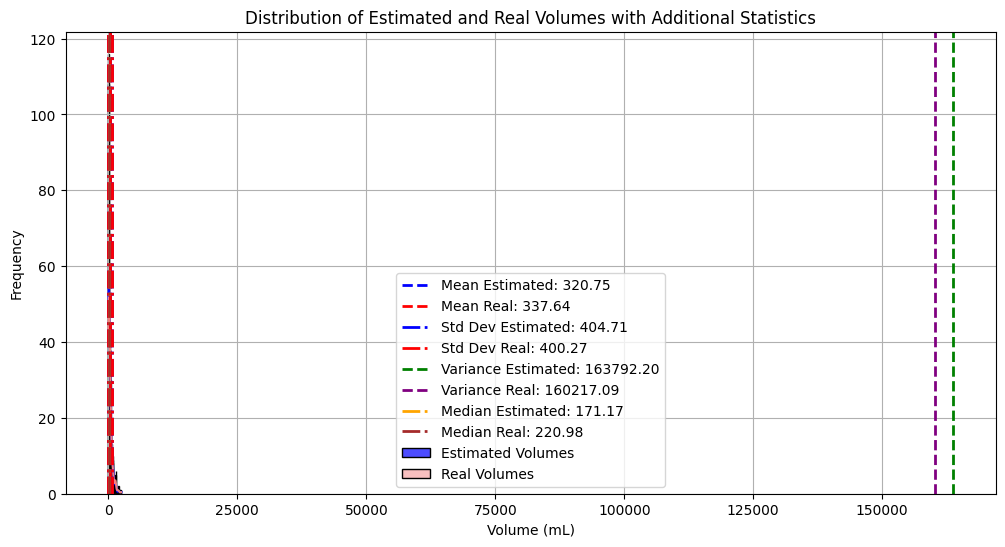

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all.xlsx'
#file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'#'TMTV_all_center_type_info.xlsx'
file_path = 'Noise_Bias_no_outlier_code.xlsx'
# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# # Calculate error
df['Error'] = abs((df['Predicted'] / 1000) - (df['GT'] / 1000))

# Sample estimated volumes and real volume (replace with your data)
estimated_volumes = df['Predicted'] / 1000
real_volume = df['GT'] / 1000

# Calculate error
# df['Error'] = abs((df['Predicted'] ) - (df['GT'] ))

# # Sample estimated volumes and real volume (replace with your data)
# estimated_volumes = df['Predicted']  # np.array([100, 105, 98, 102, 110])##
# real_volume = df['GT']

# Calculate Bias
bias = np.mean(estimated_volumes) - np.mean(real_volume)

# Calculate Noise (Standard Deviation)
noise = np.std(estimated_volumes)

# Calculate Coefficient of Variation (Variability)
coefficient_of_variation = (noise / np.mean(estimated_volumes)) * 100

# Calculate Percent Error for each estimated volume
percent_errors = np.abs((estimated_volumes - real_volume) / real_volume) * 100

# Calculate Mean and Standard Deviation of Percent Errors
mean_percent_error = np.mean(percent_errors)
std_percent_error = np.std(percent_errors)

# Calculate Variance for both Estimated and Real Volumes
variance_estimated = np.var(estimated_volumes)
variance_real = np.var(real_volume)

# Calculate Median for both Estimated and Real Volumes
median_estimated = np.median(estimated_volumes)
median_real = np.median(real_volume)

# Calculate other statistics as needed

# Visualization
plt.figure(figsize=(12, 6))

# Plot Estimated and Real Volumes as histograms

sns.histplot(data=df, x='Predicted', bins=20, color='blue', alpha=0.7, label='Estimated Volumes', kde=True)
sns.histplot(data=df, x='GT', bins=20, color='lightcoral', alpha=0.5, label='Real Volumes', kde=True)
plt.xlabel('Volume (mL)')
plt.ylabel('Frequency')
plt.legend()

# Add Mean, Std Dev, and other annotations
plt.axvline(x=np.mean(estimated_volumes), color='blue', linestyle='--', label=f'Mean Estimated: {np.mean(estimated_volumes):.2f}', linewidth=2)
plt.axvline(x=np.mean(real_volume), color='red', linestyle='--', label=f'Mean Real: {np.mean(real_volume):.2f}', linewidth=2)
plt.axvline(x=np.mean(estimated_volumes) + np.std(estimated_volumes), color='blue', linestyle='-.', label=f'Std Dev Estimated: {np.std(estimated_volumes):.2f}', linewidth=2)
plt.axvline(x=np.mean(estimated_volumes) - np.std(estimated_volumes), color='blue', linestyle='-.', linewidth=2)
plt.axvline(x=np.mean(real_volume) + np.std(real_volume), color='red', linestyle='-.', label=f'Std Dev Real: {np.std(real_volume):.2f}', linewidth=2)
plt.axvline(x=np.mean(real_volume) - np.std(real_volume), color='red', linestyle='-.', linewidth=2)

# Add Variance and Median annotations
plt.axvline(x=variance_estimated, color='green', linestyle='--', label=f'Variance Estimated: {variance_estimated:.2f}', linewidth=2)
plt.axvline(x=variance_real, color='purple', linestyle='--', label=f'Variance Real: {variance_real:.2f}', linewidth=2)
plt.axvline(x=median_estimated, color='orange', linestyle='-.', label=f'Median Estimated: {median_estimated:.2f}', linewidth=2)
plt.axvline(x=median_real, color='brown', linestyle='-.', label=f'Median Real: {median_real:.2f}', linewidth=2)

plt.legend()
plt.title('Distribution of Estimated and Real Volumes with Additional Statistics')
plt.grid(True)

plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all.xlsx'
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'#'TMTV_all_center_type_info.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)
import numpy as np

# Define true mean and standard deviation of the random variable
true_mean = np.mean(df['GT'] / 1000)
true_stddev = np.mean(df['Predicted'] / 1000)

# Number of experiments and samples per experiment
num_experiments = 1
samples_per_experiment = 379

# Initialize arrays to store estimated means and errors
estimated_means = np.zeros(num_experiments)
errors = np.zeros(num_experiments)

# Perform multiple experiments
for i in range(num_experiments):
    # Generate random samples with noise
    samples = np.random.normal(true_mean, true_stddev, samples_per_experiment)

    # Estimate the mean using sample mean
    estimated_mean = np.mean(samples)

    # Calculate the error (difference from true mean)
    error = estimated_mean - true_mean

    # Store estimated mean and error
    estimated_means[i] = estimated_mean
    errors[i] = error

# Calculate bias (average of errors)
bias = np.mean(errors)
# Calculate standard error (standard deviation of errors)
std_error = np.std(errors)

print(f"True Mean: {true_mean}")
print(f"Estimated Bias: {bias}")
print(f"Standard Error: {std_error}")


True Mean: 429.8629448942926
Estimated Bias: 19.0059379511859
Standard Error: 0.0


In [ ]:
df

,Predicted,GT,data_center,relative_error,lymphoma_type,error
0,5.152361e+05,3.709317e+05,UW,0.389032,Hodgkins,144304.35490
1,4.975318e+05,7.450739e+05,UW,0.332238,DLBCL,247542.10010
2,2.198808e+06,2.681702e+06,UW,0.180070,Hodgkins,482894.48100
3,3.372897e+04,1.803804e+04,UW,0.869880,DLBCL,15690.92533
4,1.701661e+05,1.891604e+05,UW,0.100414,Hodgkins,18994.27800
...,...,...,...,...,...,...
374,1.681000e+03,1.633000e+03,BCC,0.029394,Hodgkins,NaN
375,4.990000e+02,2.928000e+03,BCC,0.829577,Hodgkins,NaN
376,2.636000e+03,1.840000e+03,BCC,0.432609,Hodgkins,NaN
377,2.967000e+03,5.024000e+03,BCC,0.409435,Hodgkins,NaN


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Predicted'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['GT'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['relative_error'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['error'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Predicted'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['GT'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['relative_error'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['error'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['data_center'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['lymphoma_type'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df, *[[['Predicted', 'GT'], ['GT', 'relative_error'], ['relative_error', 'error']]], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df, *['data_center', 'lymphoma_type'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Predicted', 'data_center'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['Predicted', 'lymphoma_type'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['GT', 'data_center'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['GT', 'lymphoma_type'], **{'inner': 'stick'})
chart

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample estimated volumes and real volume (replace with your data)
estimated_volumes = np.array([100, 105, 98, 102, 110])
real_volume = 100

# Calculate Bias
bias = np.mean(estimated_volumes) - real_volume

# Calculate Noise (Standard Deviation)
noise = np.std(estimated_volumes)

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.hist(estimated_volumes, bins=10, alpha=0.5, label='Estimated Volumes')
plt.axvline(x=real_volume, color='red', linestyle='--', label='Real Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 2)
plt.boxplot(estimated_volumes)
plt.xticks([1], ['Estimated Volumes'])
plt.ylabel('Volume')

plt.subplot(2, 2, 3)
plt.text(0.5, 0.5, f'Bias: {bias}', ha='center', va='center', transform=plt.gca().transAxes)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.text(0.5, 0.5, f'Noise (Standard Deviation): {noise}', ha='center', va='center', transform=plt.gca().transAxes)
plt.axis('off')

plt.tight_layout()
plt.show()

# Print Results
print(f'Bias: {bias}')
print(f'Noise (Standard Deviation): {noise}')


Reading different ROI labels

In [ ]:
# import pydicom

# path_rt='DLBCL_outcome_prediction/Tyler_lymphoma/UW_074/UW_074_tmtv-rt-struct.dcm'
# # Replace 'your_rtstruct.dcm' with the path to your RT-Struct file
# rtstruct_file = path_rt

# # Load the DICOM RT-Struct file
# rtstruct = pydicom.dcmread(rtstruct_file)

# # Access structure names and contours
# for roi in rtstruct.StructureSetROISequence:
#     roi_name = roi.ROIName
#     print(f"ROI Name: {roi_name}")

#     # Check if Referenced ROI Sequence exists
#     if hasattr(roi, 'ReferencedROINumber'):
#         referenced_roi_number = roi.ReferencedROINumber
#         print(f"Referenced ROI Number: {referenced_roi_number}")

#         # Access Contour Sequence for this ROI
#         contour_sequence = rtstruct.ReferencedFrameOfReferenceSequence[0].RTReferencedStudySequence[0].RTReferencedSeriesSequence[0].ContourImageSequence[referenced_roi_number - 1].ContourSequence

#         # Access contour data
#         for contour in contour_sequence:
#             contour_data = contour.ContourData
#             print(f"Contour Data: {contour_data}")

# # You can explore other attributes and information as needed



ROI Name: TMTV ROI!


In [ ]:
#pip install nibabel numpy


In [ ]:
# import nibabel as nib

# # Load the NIfTI file
# nii_file = nib.load('DLBCL_outcome_prediction/Tyler_lymphoma/UW_074/UW_074_REF.nii.gz')
# # Access the image data as a NumPy array
# image_data = nii_file.get_fdata()

# # Access the NIfTI header
# nii_header = nii_file.header
# # Get unique labels in the image data
# unique_labels = np.unique(image_data)
# new_mask_data = np.where((image_data <= 6)& (image_data!=0), 1, 0)
# # image_data_n=image_data<=6
# unique_labels_n = np.unique(new_mask_data)
# print("Unique Labels:", unique_labels_n)

Unique Labels: [0 1]


In [ ]:
# import nibabel as nib
# import numpy as np

# # Load the NIfTI file
# nii_file = nib.load('DLBCL_outcome_prediction/Tyler_lymphoma/UW_074/UW_074_REF.nii.gz')

# # Access the image data as a NumPy array
# image_data = nii_file.get_fdata()

# # Create a new mask with labels less than 6
# new_mask_data = np.where(image_data <= 6, image_data, 0)

# # Create a new NIfTI image with the modified data and the same header
# new_mask_nii = nib.Nifti1Image(new_mask_data, nii_file.affine, header=nii_file.header)

# nii_header = new_mask_nii.header
# # Get unique labels in the image data
# unique_labels = np.unique(image_data)
# print("Unique Labels:", unique_labels)
# image_data_new = np.where(image_data <= 6, 1, 0)
# # # Save the new NIfTI image to a .nii.gz file
# # nib.save(new_mask_nii, 'new_mask.nii.gz')


Unique Labels: [ 0.  6. 10.]


In [ ]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd

def calculate_dice_score(gt_image, pred_image):
    gt_arr = sitk.GetArrayFromImage(gt_image)
    pred_arr = sitk.GetArrayFromImage(pred_image)
    intersection = np.logical_and(gt_arr, pred_arr).sum()
    dice = (2.0 * intersection) / (gt_arr.sum() + pred_arr.sum())
    return dice

def calculate_metrics(gt_image, pred_image):
    gt_arr = sitk.GetArrayFromImage(gt_image)
    pred_arr = sitk.GetArrayFromImage(pred_image)

    true_positive = np.logical_and(gt_arr, pred_arr).sum()
    false_positive = np.logical_and(np.logical_not(gt_arr), pred_arr).sum()
    false_negative = np.logical_and(gt_arr, np.logical_not(pred_arr)).sum()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    return precision, recall, false_positive, false_negative

results = []

input_path= 'DLBCL_outcome_prediction/Tyler_lymphoma'  # Replace this with your desired directory
output_dir='/content/drive/MyDrive/TMTV_Dmax_EJNMMI/'
input_path = '/content/drive/MyDrive/' + input_path
case_ids = os.listdir(input_path)

for n, case_name in tqdm(enumerate(case_ids), total=len(case_ids)):
    path_img_nii = str(input_path) + "/" + str(case_name)  # for GT worked
    pred_path = glob.glob(path_img_nii + "/"+ str(case_name) +"_SEG.nii.gz")[0] #for _REF _SEG
    gt_path = glob.glob(path_img_nii + "/"+ str(case_name) +"_REF.nii.gz")[0] #

    print(pred_path)

    gt_image = sitk.ReadImage(gt_path)
    pred_image = sitk.ReadImage(pred_path)

    dice = calculate_dice_score(gt_image, pred_image)
    precision, recall, false_positive, false_negative = calculate_metrics(gt_image, pred_image)

    results.append({
        "PatientID": case_name,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall,
        "FalsePositiveVolume": false_positive,
        "FalseNegativeVolume": false_negative
    })

# Convert results list to DataFrame and save to CSV
# results_df = pd.DataFrame(results)
# results_df.to_csv("metrics_results.csv", index=False)
results_df = pd.DataFrame(results)
#results_df.to_csv("metrics_results.csv", index=False)
write_to_csv_file(results_df, output_dir, file_name="metrics_results_UW")

In [ ]:
!pip install numpy matplotlib pandas openpyxl

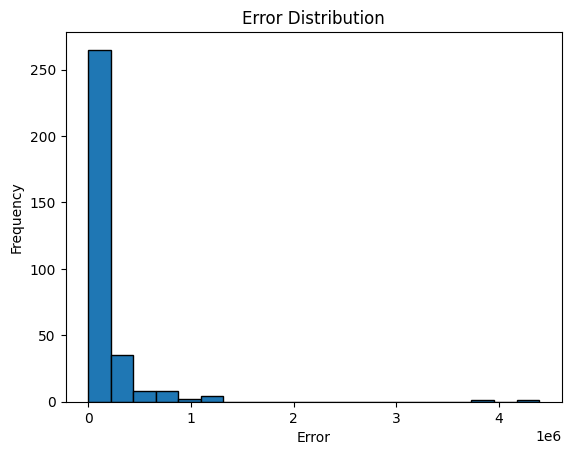

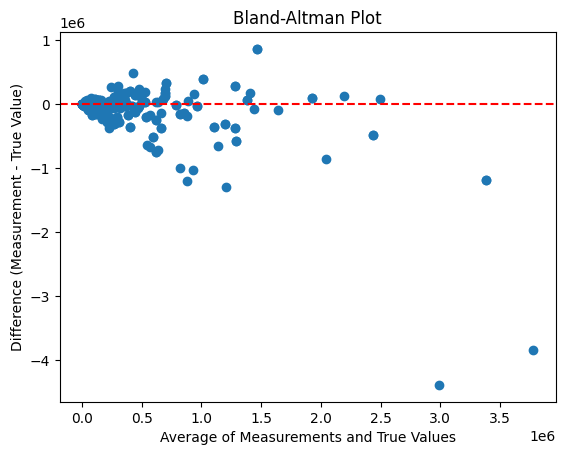

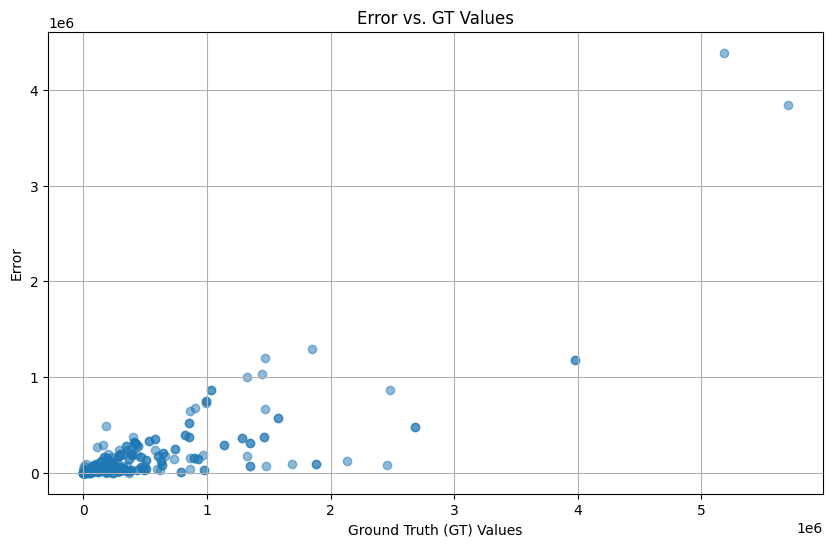

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all.xlsx'
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'
# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Extract measurement and true value columns from the DataFrame
measurements = df['Predicted']  # Replace 'Measurement' with the actual column name
true_values = df['GT']    # Replace 'True Value' with the actual column name

# Calculate bias
true_value = true_values.mean()  # Use the mean of true values as a reference
bias = measurements.mean() - true_value

# Calculate error
error = abs(measurements - true_values)

# Create error distribution plot
import matplotlib.pyplot as plt
plt.hist(error, bins=20, edgecolor='k')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()

# Create Bland-Altman plot
average = (measurements + true_values) / 2
difference = measurements - true_values
plt.scatter(average, difference)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Average of Measurements and True Values')
plt.ylabel('Difference (Measurement - True Value)')
plt.title('Bland-Altman Plot')
plt.show()

# Create a scatter plot of error vs. GT values
plt.figure(figsize=(10, 6))
plt.scatter(true_values, error, alpha=0.5)
plt.xlabel('Ground Truth (GT) Values')
plt.ylabel('Error')
plt.title('Error vs. GT Values')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Extract measurement, true value, and data center columns from the DataFrame
measurements = df['Predicted']  # Replace 'Measurement' with the actual column name
true_values = df['GT']  # Replace 'True Value' with the actual column name
data_centers = df['data_center']  # Replace 'data_center' with the actual column name

# Calculate error
error = abs(measurements - true_values)

# Define a colormap for data centers (you can customize this)
colormap = {
    'UW': 'blue',
    'BCC': 'green',
    'SK': 'red'
    # Add more centers and corresponding colors as needed
}

# Create a scatter plot with color-coded points for each data center
plt.figure(figsize=(10, 6))
for center, color in colormap.items():
    mask = (data_centers == center)
    plt.scatter(true_values[mask], error[mask], alpha=0.5, label=center, color=color)

plt.xlabel('Ground Truth (GT) Values')
plt.ylabel('Error')
plt.title('Error vs. GT Values (Color-coded by Data Center)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Extract measurement, true value, and data center columns from the DataFrame
measurements = df['Predicted']  # Replace 'Measurement' with the actual column name
true_values = df['GT']  # Replace 'True Value' with the actual column name
data_centers = df['data_center']  # Replace 'data_center' with the actual column name

# Calculate error
error = abs(measurements - true_values)

# Define the figure size
plt.figure(figsize=(12, 8))

# Create a scatter plot with Seaborn
sns.scatterplot(data=df, x='GT', y='Predicted', hue='data_center', palette='Set1', alpha=0.7)

# Add labels and a title
plt.xlabel('Ground Truth (GT) Values')
plt.ylabel('Error')
plt.title('Error vs. GT Values (Color-coded by Data Center)')

# Show the legend
plt.legend(title='Data Center', loc='upper right')

# Show the plot
plt.grid(True)
plt.show()



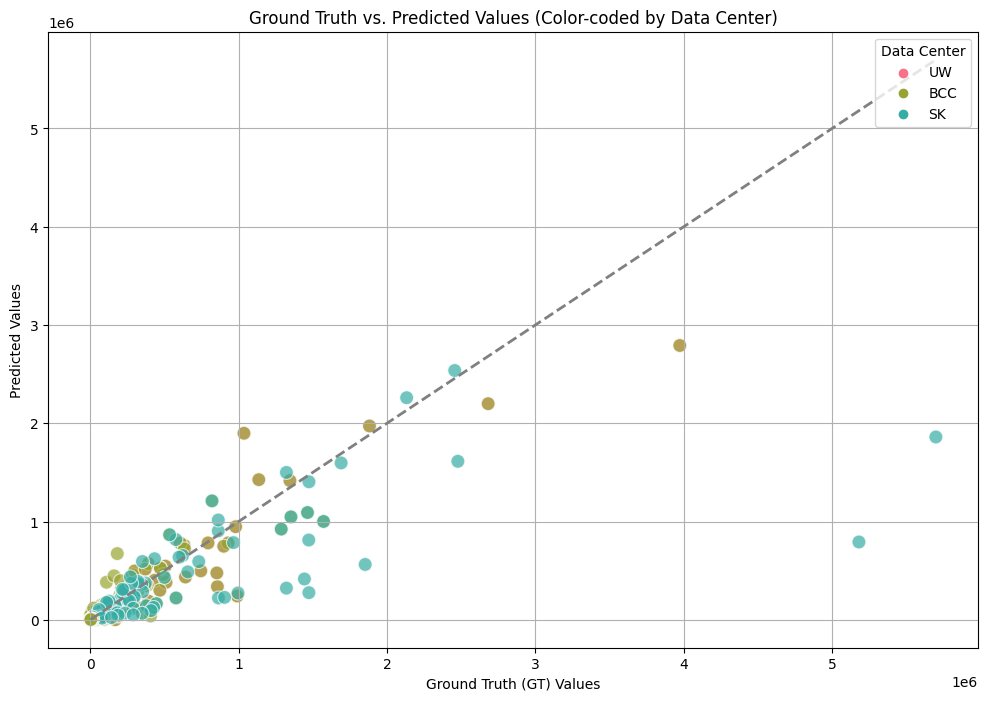

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Extract measurement, true value, and data center columns from the DataFrame
measurements = df['Predicted']  # Replace 'Predicted' with the actual column name
true_values = df['GT']  # Replace 'GT' with the actual column name
data_centers = df['data_center']  # Replace 'data_center' with the actual column name

# Calculate error
error = abs(measurements - true_values)

# Calculate Spearman correlation
spearman_corr, _ = spearmanr(df['GT'], df['Predicted'])

# Define a custom color palette for better discrimination
custom_palette = sns.color_palette("husl", len(data_centers.unique()))

# Define the figure size
plt.figure(figsize=(12, 8))

# Create a scatter plot with Seaborn using the custom palette
sns.scatterplot(data=df, x='GT', y='Predicted', hue='data_center', palette=custom_palette, alpha=0.7, s=100)

# Draw the x=y line
plt.plot([min(df['GT']), max(df['GT'])], [min(df['GT']), max(df['GT'])], linestyle='--', color='gray', linewidth=2)

# Add labels and a title
plt.xlabel('Ground Truth (GT) Values')
plt.ylabel('Predicted Values')
plt.title(f'Ground Truth vs. Predicted Values (Color-coded by Data Center)')

# Show the legend
plt.legend(title='Data Center', loc='upper right')

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
df['data_center'].unique()

array(['UW', 'BCC', 'SK', nan], dtype=object)

<ipython-input-4-9844b90d69fe>:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=subset_df, x='GT', y='Predicted', palette=custom_palette, alpha=0.7, s=100, edgecolor="black")


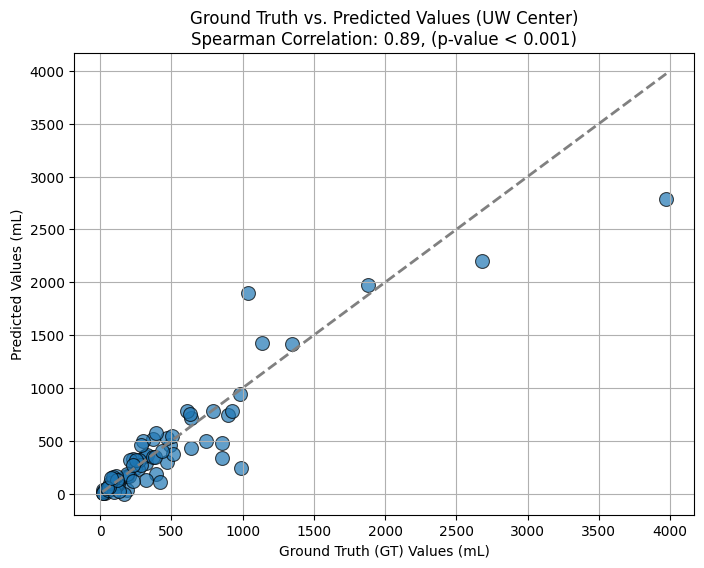

<ipython-input-4-9844b90d69fe>:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=subset_df, x='GT', y='Predicted', palette=custom_palette, alpha=0.7, s=100, edgecolor="black")


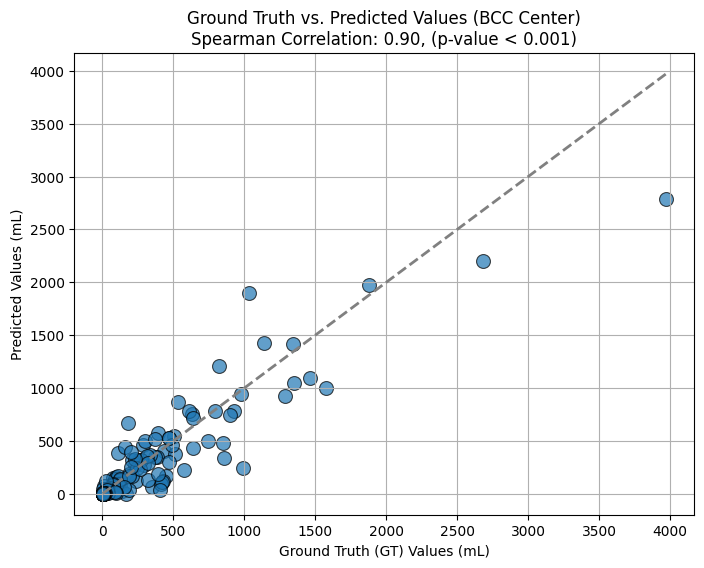

<ipython-input-4-9844b90d69fe>:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=subset_df, x='GT', y='Predicted', palette=custom_palette, alpha=0.7, s=100, edgecolor="black")


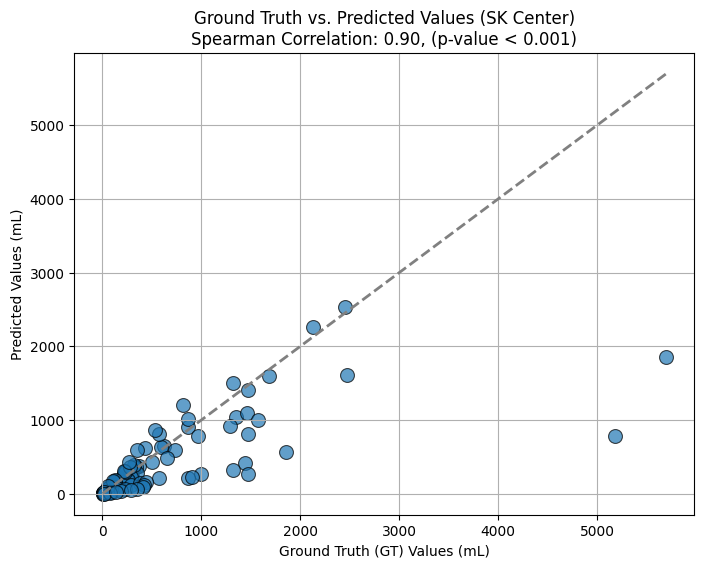

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)
df['GT'] = df['GT'] / 1000
df['Predicted'] = df['Predicted'] / 1000

# Define a custom color palette for better discrimination
custom_palette = sns.color_palette("husl", len(df['data_center'].unique()))

# Iterate through unique data centers and create separate plots
for center in df['data_center'].unique():
    # Subset the data for the current data center
    subset_df = df[df['data_center'] == center]

    # Calculate Spearman correlation and its p-value for the subset
    spearman_corr, p_value = spearmanr(subset_df['GT'], subset_df['Predicted'])

    # Check if the correlation is NaN and skip the plot if NaN
    if not np.isnan(spearman_corr):
        # Define the figure size for each plot
        plt.figure(figsize=(8, 6))

        # Create a scatter plot with Seaborn using the custom palette
        sns.scatterplot(data=subset_df, x='GT', y='Predicted', palette=custom_palette, alpha=0.7, s=100, edgecolor="black")

        # Draw the x=y line
        plt.plot([min(subset_df['GT']), max(subset_df['GT'])], [min(subset_df['GT']), max(subset_df['GT'])], linestyle='--', color='gray', linewidth=2)

        # Determine how to display p-value in the title
        if p_value < 0.001:
            p_value_str = "(p-value < 0.001)"
        else:
            p_value_str = f"p-value: {p_value:.4f}"

        # Add labels and a title for each plot with Spearman correlation and p-value
        plt.xlabel('Ground Truth (GT) Values (mL)')
        plt.ylabel('Predicted Values (mL)')
        plt.title(f'Ground Truth vs. Predicted Values ({center} Center)\nSpearman Correlation: {spearman_corr:.2f}, {p_value_str}')

        # Show each plot
        plt.grid(True)
        plt.show()





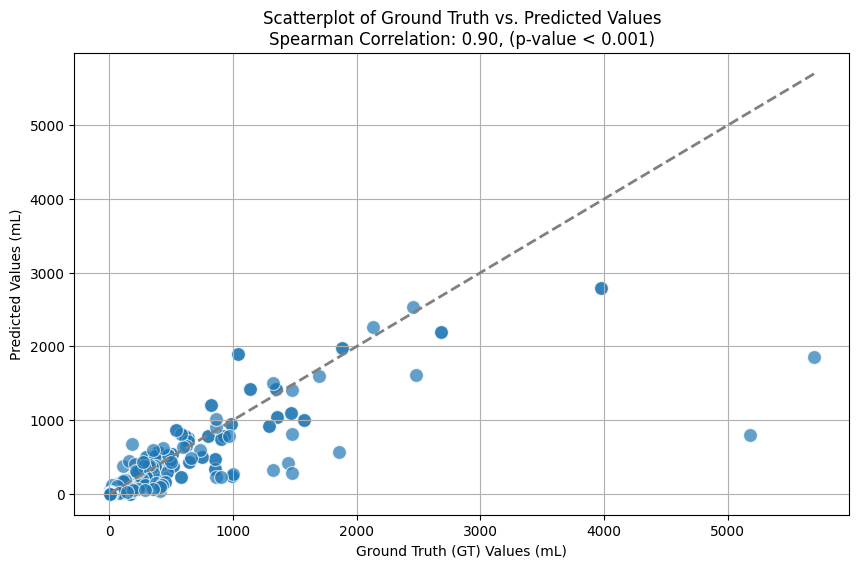

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

df['GT'] = df['GT'] / 1000
df['Predicted'] = df['Predicted'] / 1000

# Remove rows with NaN values in 'GT' and 'Predicted' columns
df.dropna(subset=['GT', 'Predicted'], inplace=True)

# Calculate Spearman correlation and its p-value for the entire dataset
spearman_corr, p_value = spearmanr(df['GT'], df['Predicted'])

# Define the figure size
plt.figure(figsize=(10, 6))

# Create a scatter plot with Seaborn for the entire dataset
sns.scatterplot(data=df, x='GT', y='Predicted', alpha=0.7, s=100)

# Add labels and a title with Spearman correlation and p-value
plt.xlabel('Ground Truth (GT) Values (mL)')
plt.ylabel('Predicted Values (mL)')
if p_value < 0.001:
    p_value_str = "(p-value < 0.001)"
else:
    p_value_str = f"p-value: {p_value:.4f}"
plt.title(f'Scatterplot of Ground Truth vs. Predicted Values\nSpearman Correlation: {spearman_corr:.2f}, {p_value_str}')
plt.plot([min(df['GT']), max(df['GT'])], [min(df['GT']), max(df['GT'])], linestyle='--', color='gray', linewidth=2)

# Show the plot
plt.grid(True)
plt.show()


Regression Formula: Predicted = 0.5800 * GT + 97.7921


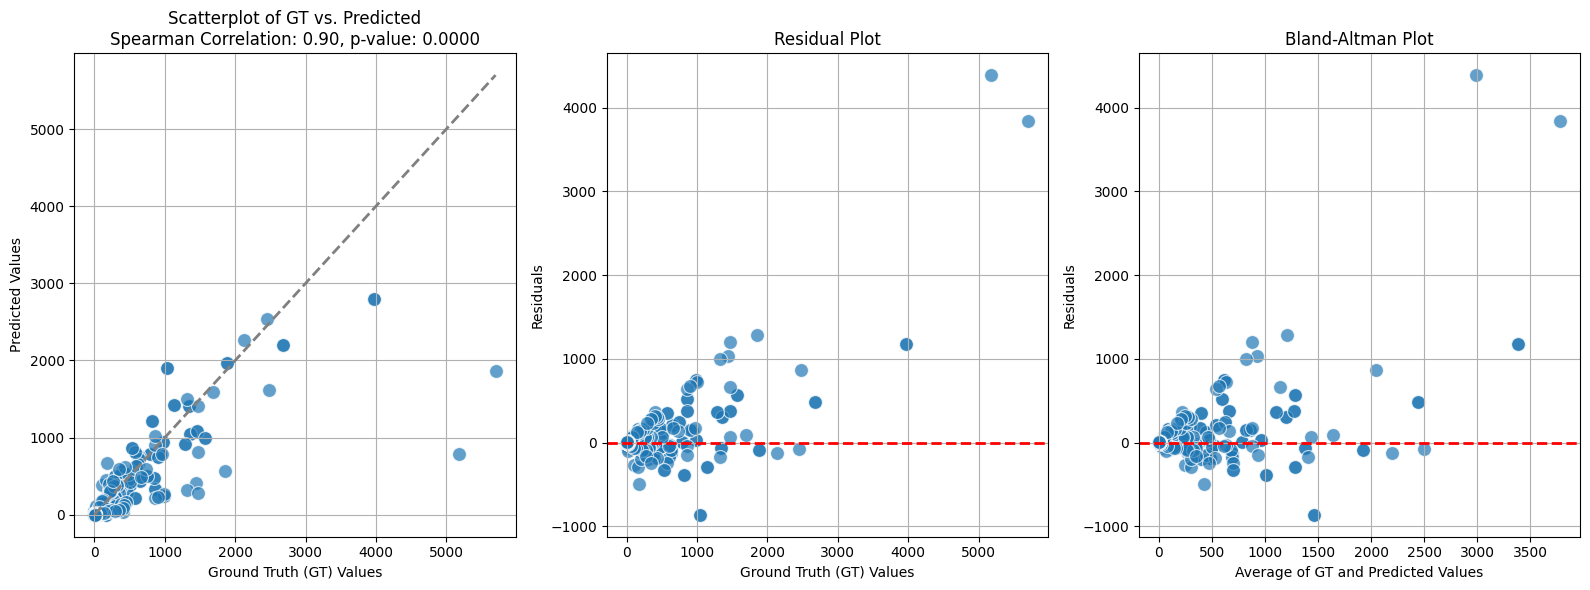

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, linregress

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)
df['GT'] = df['GT'] / 1000
df['Predicted'] = df['Predicted'] / 1000

# Remove rows with NaN values in 'GT' and 'Predicted' columns
df.dropna(subset=['GT', 'Predicted'], inplace=True)


# Calculate Spearman correlation and its p-value for the entire dataset
spearman_corr, p_value = spearmanr(df['GT'], df['Predicted'])

# Calculate the residuals (differences between GT and Predicted)
residuals = df['GT'] - df['Predicted']

# Calculate linear regression
slope, intercept, r_value, p_value_reg, std_err = linregress(df['GT'], df['Predicted'])

# Define the figure size for the subplots
plt.figure(figsize=(16, 6))

# Create the scatter plot for GT vs. Predicted
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='GT', y='Predicted', alpha=0.7, s=100)
plt.xlabel('Ground Truth (GT) Values')
plt.ylabel('Predicted Values')
plt.title(f'Scatterplot of GT vs. Predicted\nSpearman Correlation: {spearman_corr:.2f}, p-value: {p_value:.4f}')
plt.plot([min(df['GT']), max(df['GT'])], [min(df['GT']), max(df['GT'])], linestyle='--', color='gray', linewidth=2)
plt.grid(True)

# Create the residual plot
plt.subplot(1, 3, 2)
sns.scatterplot(x=df['GT'], y=residuals, alpha=0.7, s=100)
plt.xlabel('Ground Truth (GT) Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.grid(True)

# Create the Bland-Altman plot
plt.subplot(1, 3, 3)
sns.scatterplot(x=(df['GT'] + df['Predicted']) / 2, y=residuals, alpha=0.7, s=100)
plt.xlabel('Average of GT and Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Bland-Altman Plot')
plt.grid(True)

# Adjust layout and show the plots
plt.tight_layout()

# Calculate regression formula
regression_formula = f'Predicted = {slope:.4f} * GT + {intercept:.4f}'

# Display the regression formula
print(f'Regression Formula: {regression_formula}')
plt.show()



Mean Error: 82.7708
Standard Deviation of Error: 285.7503
Regression Formula: Predicted = 0.5800 * GT + 97.7921


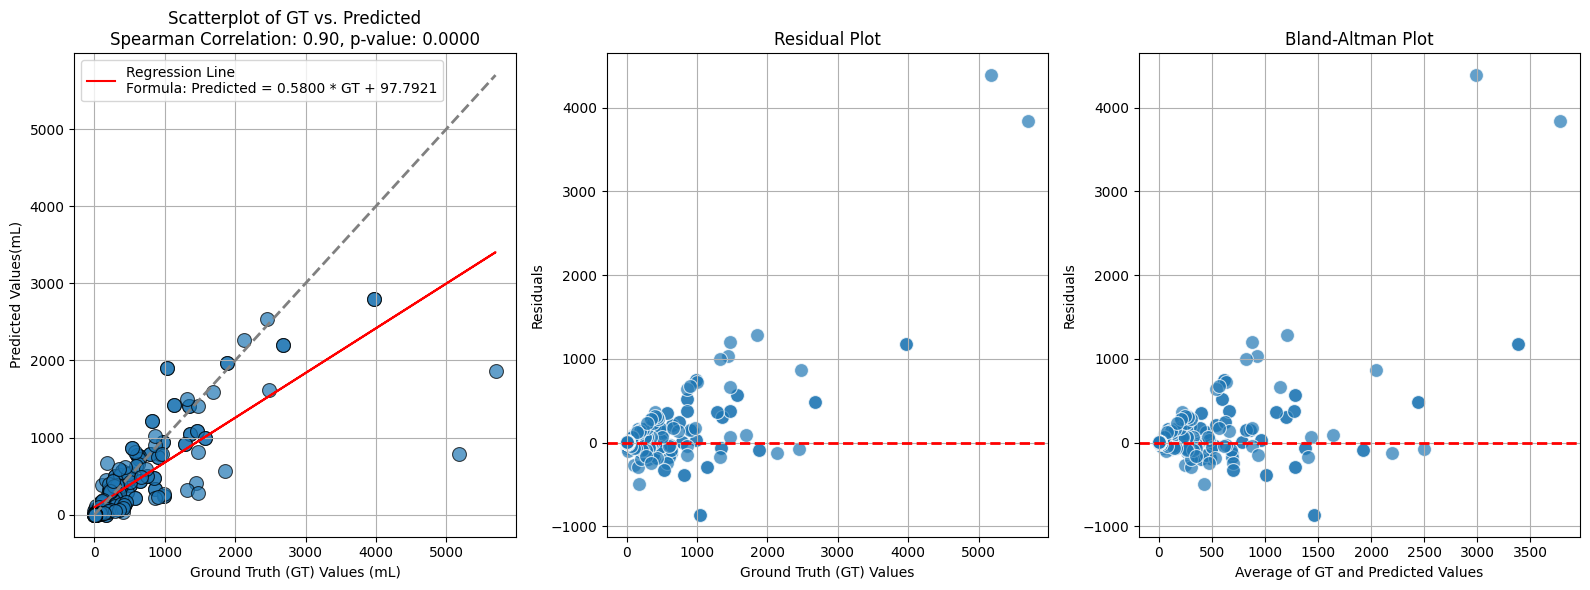

Bias: 82.7708
Variance: 155654.4305


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, linregress

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'
#file_path = 'Noise_Bias_no_outlier_code.xlsx'
# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)
df['GT'] = df['GT'] / 1000
df['Predicted'] = df['Predicted'] / 1000

# Remove rows with NaN values in 'GT' and 'Predicted' columns
df.dropna(subset=['GT', 'Predicted'], inplace=True)

# Calculate Spearman correlation and its p-value for the entire dataset
spearman_corr, p_value = spearmanr(df['GT'], df['Predicted'])

# Calculate linear regression
slope, intercept, r_value, p_value_reg, std_err = linregress(df['GT'], df['Predicted'])

# Calculate the residuals (differences between GT and Predicted)
residuals = df['GT'] - df['Predicted']

# Calculate the regression values
regression_values = slope * df['GT'] + intercept

# Calculate the error between regression values and actual values
error = df['GT'] - regression_values

# Define the figure size for the subplots
plt.figure(figsize=(16, 6))

# Create the scatter plot for GT vs. Predicted with regression line and error
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='GT', y='Predicted', alpha=0.7, s=100, edgecolor="black")
plt.plot(df['GT'], regression_values, color='red', label=f'Regression Line\nFormula: Predicted = {slope:.4f} * GT + {intercept:.4f}')
plt.xlabel('Ground Truth (GT) Values (mL)')
plt.ylabel('Predicted Values(mL)')
plt.title(f'Scatterplot of GT vs. Predicted\nSpearman Correlation: {spearman_corr:.2f}, p-value: {p_value:.4f}')
plt.plot([min(df['GT']), max(df['GT'])], [min(df['GT']), max(df['GT'])], linestyle='--', color='gray', linewidth=2)
plt.legend()
plt.grid(True)

# Create the residual plot
plt.subplot(1, 3, 2)
sns.scatterplot(x=df['GT'], y=residuals, alpha=0.7, s=100)
plt.xlabel('Ground Truth (GT) Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.grid(True)

# Create the Bland-Altman plot
plt.subplot(1, 3, 3)
sns.scatterplot(x=(df['GT'] + df['Predicted']) / 2, y=residuals, alpha=0.7, s=100)
plt.xlabel('Average of GT and Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Bland-Altman Plot')
plt.grid(True)

# Adjust layout and show the plots
plt.tight_layout()

# Display the error statistics
mean_error = np.mean(error)
std_error = np.std(error)
print(f'Mean Error: {mean_error:.4f}')
print(f'Standard Deviation of Error: {std_error:.4f}')

# Calculate regression formula
regression_formula = f'Predicted = {slope:.4f} * GT + {intercept:.4f}'

# Display the regression formula and error statistics
print(f'Regression Formula: {regression_formula}')
plt.show()

# Calculate the bias
bias = np.mean(residuals)

# Calculate the variance
variance = np.mean((regression_values - np.mean(regression_values))**2)

print(f"Bias: {bias:.4f}")
print(f"Variance: {variance:.4f}")



Mean Error: 16.8904
Standard Deviation of Error: 16.0239


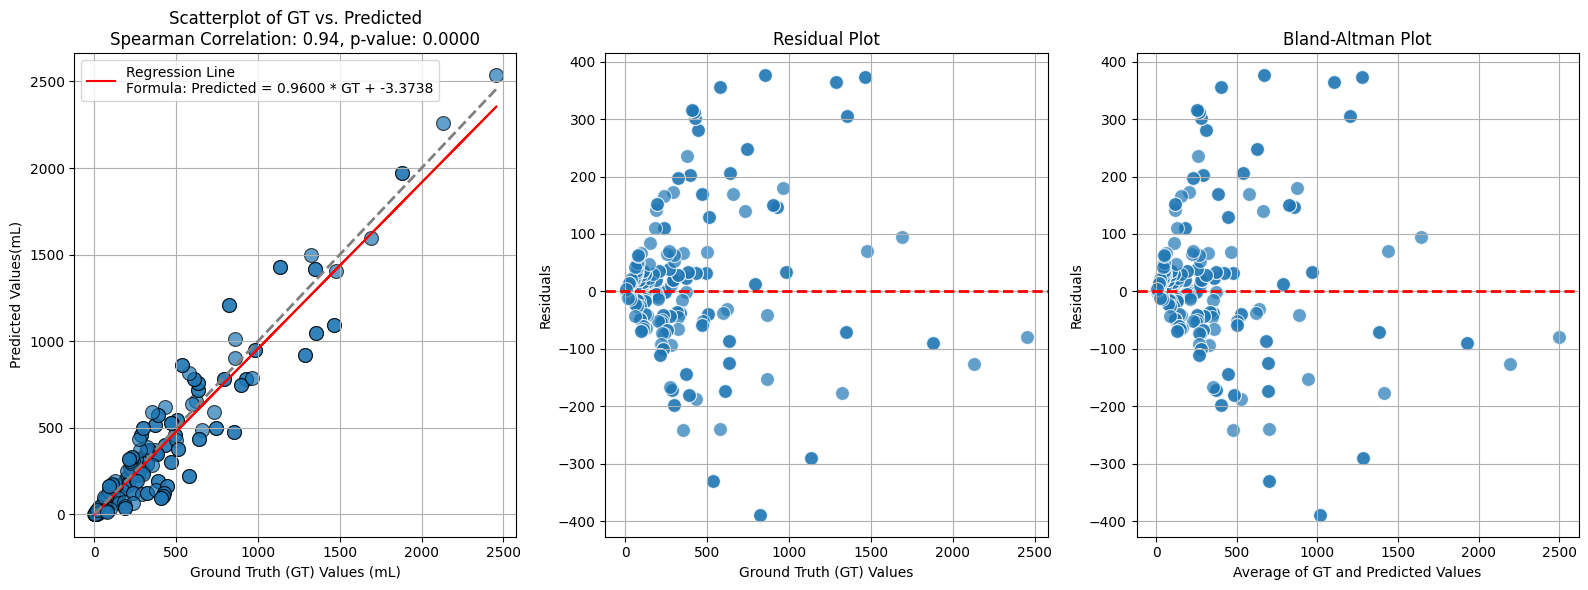

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, linregress

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'
file_path = 'Noise_Bias_no_outlier_code.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)
# df['GT'] = df['GT'] / 1000
# df['Predicted'] = df['Predicted'] / 1000

# Remove rows with NaN values in 'GT' and 'Predicted' columns
df.dropna(subset=['GT', 'Predicted'], inplace=True)

# Calculate Spearman correlation and its p-value for the entire dataset
spearman_corr, p_value = spearmanr(df['GT'], df['Predicted'])

# Calculate linear regression
slope, intercept, r_value, p_value_reg, std_err = linregress(df['GT'], df['Predicted'])

# Calculate the residuals (differences between GT and Predicted)
residuals = df['GT'] - df['Predicted']

# Calculate the regression values
regression_values = slope * df['GT'] + intercept

# Calculate the error between regression values and actual values
error = df['GT'] - regression_values

# Calculate the relative error
relative_error = (df['Predicted'] - df['GT']) / df['GT']

# Define the figure size for the subplots
plt.figure(figsize=(16, 6))

# Create the scatter plot for GT vs. Predicted with regression line and error
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='GT', y='Predicted', alpha=0.7, s=100, edgecolor="black")
plt.plot(df['GT'], regression_values, color='red', label=f'Regression Line\nFormula: Predicted = {slope:.4f} * GT + {intercept:.4f}')
plt.xlabel('Ground Truth (GT) Values (mL)')
plt.ylabel('Predicted Values(mL)')
plt.title(f'Scatterplot of GT vs. Predicted\nSpearman Correlation: {spearman_corr:.2f}, p-value: {p_value:.4f}')
plt.plot([min(df['GT']), max(df['GT'])], [min(df['GT']), max(df['GT'])], linestyle='--', color='gray', linewidth=2)
plt.legend()
plt.grid(True)

# Create the residual plot
plt.subplot(1, 3, 2)
sns.scatterplot(x=df['GT'], y=residuals, alpha=0.7, s=100)
plt.xlabel('Ground Truth (GT) Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.grid(True)

# Create the Bland-Altman plot
plt.subplot(1, 3, 3)
sns.scatterplot(x=(df['GT'] + df['Predicted']) / 2, y=residuals, alpha=0.7, s=100)
plt.xlabel('Average of GT and Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Bland-Altman Plot')
plt.grid(True)

# Adjust layout and show the plots
plt.tight_layout()

# Display the error statistics
mean_error = np.mean(error)
std_error = np.std(error)
print(f'Mean Error: {mean_error:.4f}')
print(f'Standard Deviation of Error: {std_error:.4f}')

#


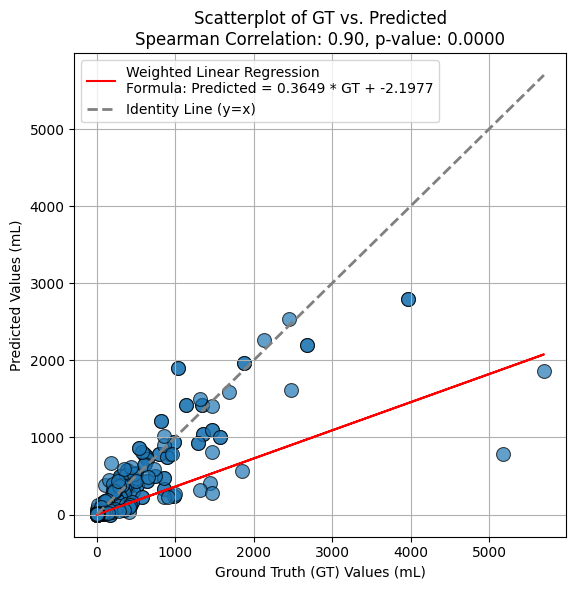

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import spearmanr

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'
#file_path = 'Noise_Bias_no_outlier_code.xlsx'
# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)
df['GT'] = df['GT'] / 1000
df['Predicted'] = df['Predicted'] / 1000

# Remove rows with NaN values in 'GT' and 'Predicted' columns
df.dropna(subset=['GT', 'Predicted'], inplace=True)

# Calculate Spearman correlation and its p-value for the entire dataset
spearman_corr, p_value = spearmanr(df['GT'], df['Predicted'])

# Perform weighted linear regression
X = sm.add_constant(df['GT'])
y = df['Predicted']

# You can assign weights based on the residuals to give more importance to smaller residuals.
weights = 1 / np.abs(y - X.dot([1, 0]))

model = sm.WLS(y, X, weights=weights).fit()
slope = model.params[1]
intercept = model.params[0]

# Calculate the regression values
regression_values = model.predict(X)

# Define the figure size for the subplots
plt.figure(figsize=(16, 6))

# Create the scatter plot for GT vs. Predicted with the weighted linear regression line
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='GT', y='Predicted', alpha=0.7, s=100, edgecolor="black")
plt.plot(df['GT'], regression_values, color='red', label=f'Weighted Linear Regression\nFormula: Predicted = {slope:.4f} * GT + {intercept:.4f}')
plt.plot([min(df['GT']), max(df['GT'])], [min(df['GT']), max(df['GT'])], linestyle='--', color='gray', linewidth=2, label='Identity Line (y=x)')
plt.xlabel('Ground Truth (GT) Values (mL)')
plt.ylabel('Predicted Values (mL)')
plt.title(f'Scatterplot of GT vs. Predicted\nSpearman Correlation: {spearman_corr:.2f}, p-value: {p_value:.4f}')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
import numpy as np

# Assuming you have a list of predicted values (predictions) and true target values (true_values)
mse = np.mean((df['Predicted'] - df['GT']) ** 2)  # Calculate MSE

# Calculate Bias
mean_predicted = np.mean(df['Predicted'])
bias2 = np.mean((mean_predicted - df['GT']) ** 2)

# Calculate Variance
variance = np.mean((df['Predicted'] - mean_predicted) ** 2)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Square Root of Bias and Variance
bias = np.sqrt(bias)
noise = np.sqrt(variance)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Bias:", bias)
print("Variance:", variance)
print("Square Root of Bias:", bias)
print("Square Root of Variance:", noise)



Mean Squared Error (MSE): 167215034560.84515
Root Mean Squared Error (RMSE): 408919.3497021695
Bias: 685.2978859716585
Variance: 234365218651.31326
Square Root of Bias: 685.2978859716585
Square Root of Variance: 484112.8160370403


In [ ]:
import numpy as np

# Assuming you have 'GT' and 'Predicted' columns in a DataFrame
# Calculate the absolute vertical deviation for each data point
df['Deviation'] = np.abs(df['Predicted'] - df['GT'])

# Calculate the mean absolute error (MAE) and root mean squared error (RMSE)
mae = df['Deviation'].mean()
rmse = np.sqrt((df['Deviation'] ** 2).mean())

print(f"Mean Absolute Error (MAE): {mae:.4f} mL")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f} mL")

# Calculate error
df['Error'] = abs((df['Predicted']) - (df['GT']))
df['Relative_Error'] = abs((df['Predicted'] - df['GT']) / df['GT'])

Average_E=df['Error'] .mean()
Average_RE=df['Relative_Error'].mean()

print(f"Average Relative Error: {Average_RE:.4f} ")
print(f"Average error: {Average_E=:.4f} mL")

Mean Absolute Error (MAE): 156.9732 mL
Root Mean Squared Error (RMSE): 408.9193 mL
Average Relative Error: 0.5344 mL
Average error: Average_E=156.9732 mL


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate Spearman correlation and its p-value for the entire dataset
spearman_corr, p_value = spearmanr(df['GT'], df['Predicted'])

# Define the figure size
plt.figure(figsize=(10, 6))

# Create a scatter plot with Seaborn for the entire dataset
sns.scatterplot(data=df, x='GT', y='Predicted', alpha=0.7, s=100)

# Add labels and a title with Spearman correlation and p-value
plt.xlabel('Ground Truth (GT) Values')
plt.ylabel('Predicted Values')
if p_value < 0.001:
    p_value_str = "(p-value < 0.001)"
else:
    p_value_str = f"p-value: {p_value:.4f}"
plt.title(f'Scatterplot of Ground Truth vs. Predicted Values\nSpearman Correlation: {spearman_corr:.2f}, {p_value_str}')

# Show the plot
plt.grid(True)
plt.show()


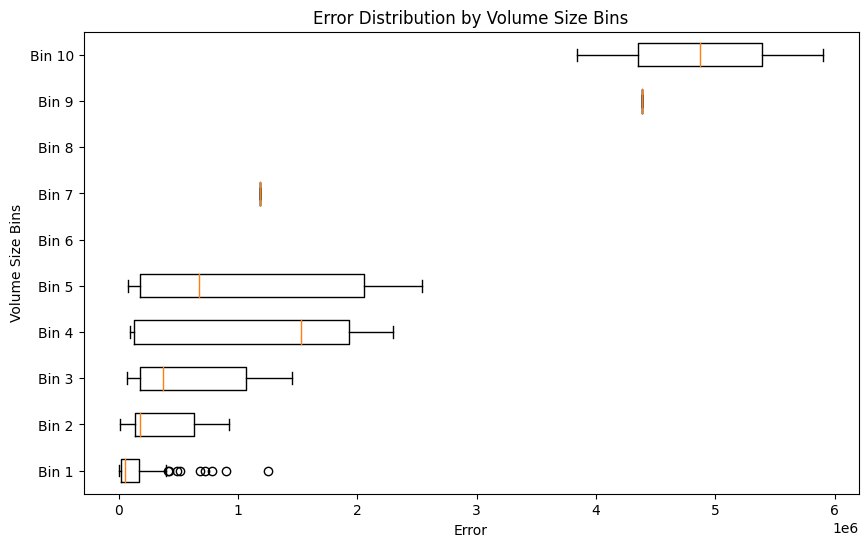

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Extract measurement and true value columns from the DataFrame
measurements = df['Predicted']  # Replace 'Measurement' with the actual column name
true_values = df['GT']    # Replace 'True Value' with the actual column name
# Calculate error
error = abs(measurements - true_values)

# Define the number of bins and bin edges for volume size
num_bins = 10  # You can adjust the number of bins as needed
volume_bins = np.linspace(df['GT'].min(), df['GT'].max(), num_bins + 1)

# Create a list to hold the error values for each bin
error_by_volume = [[] for _ in range(num_bins)]

# Populate the error values into the respective bins
for i in range(num_bins):
    if i == num_bins - 1:
        # For the last bin, include values that are equal to the maximum volume
        mask = (df['GT'] >= volume_bins[i])
    else:
        mask = (df['GT'] >= volume_bins[i]) & (df['GT'] < volume_bins[i + 1])

    error_by_volume[i] = error[mask]

# Create a boxplot to show the error distribution by volume size
plt.figure(figsize=(10, 6))
plt.boxplot(error_by_volume, labels=[f'Bin {i+1}' for i in range(num_bins)], vert=False)
plt.xlabel('Error')
plt.ylabel('Volume Size Bins')
plt.title('Error Distribution by Volume Size Bins')
plt.show()

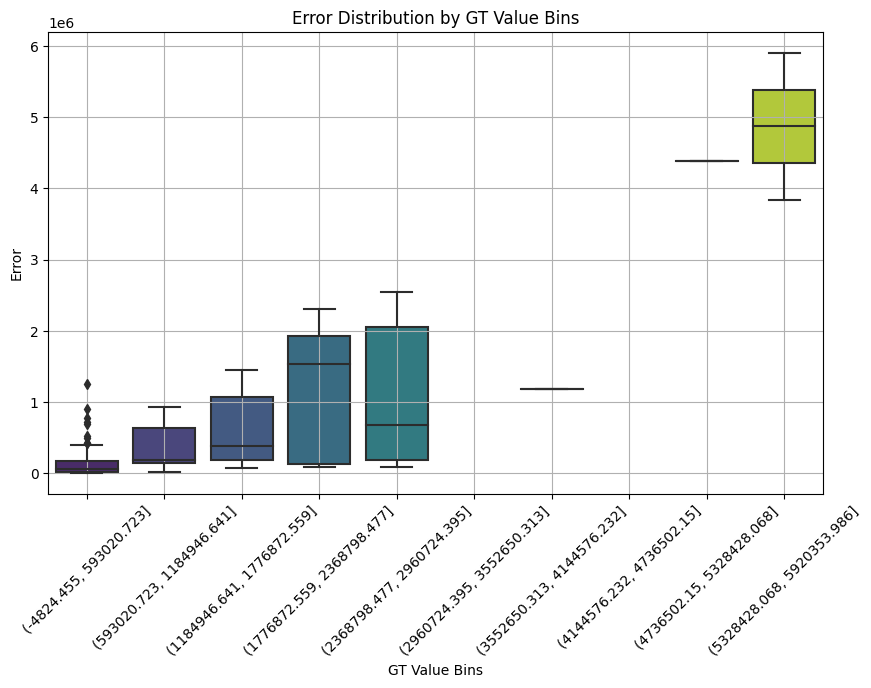

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate error
df['Error'] = abs(df['Predicted'] - df['GT'])

# Define the number of bins and bin edges for GT values
num_bins = 10  # You can adjust the number of bins as needed
volume_bins = pd.cut(df['GT'], bins=num_bins)

# Create a box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='Error', data=df, palette='viridis')
plt.xlabel('GT Value Bins')
plt.ylabel('Error')
plt.title('Error Distribution by GT Value Bins')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


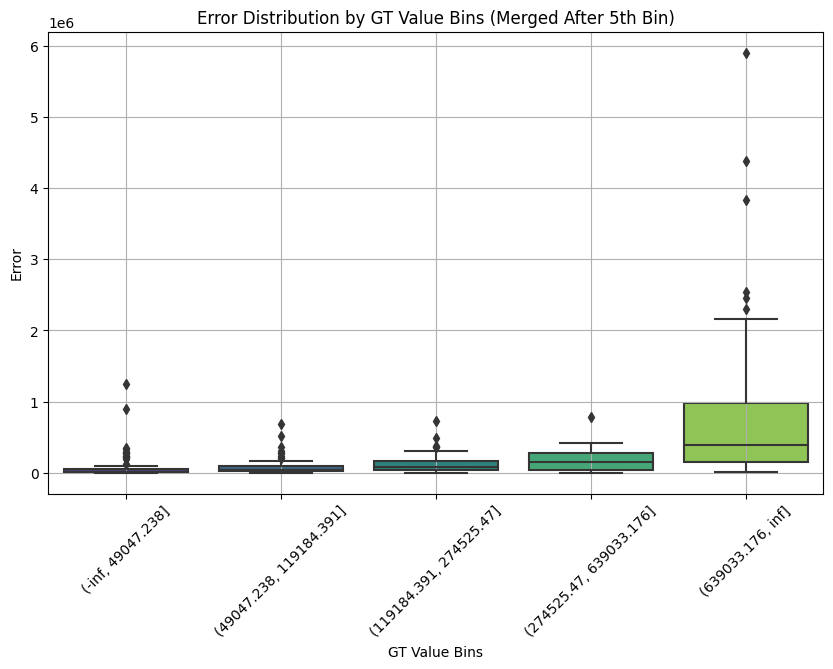

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate error
df['Error'] = abs(df['Predicted'] - df['GT'])

# Define the number of bins and bin edges for GT values
num_bins = 10  # You can adjust the number of bins as needed

# Create bins with merging after the 5th bin
volume_bins = pd.cut(df['GT'], bins=[-float('inf'), *df['GT'].quantile([0.2, 0.4, 0.6, 0.8]).values, float('inf')])

# Create a box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='Error', data=df, palette='viridis')
plt.xlabel('GT Value Bins')
plt.ylabel('Error')
plt.title('Error Distribution by GT Value Bins (Merged After 5th Bin)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


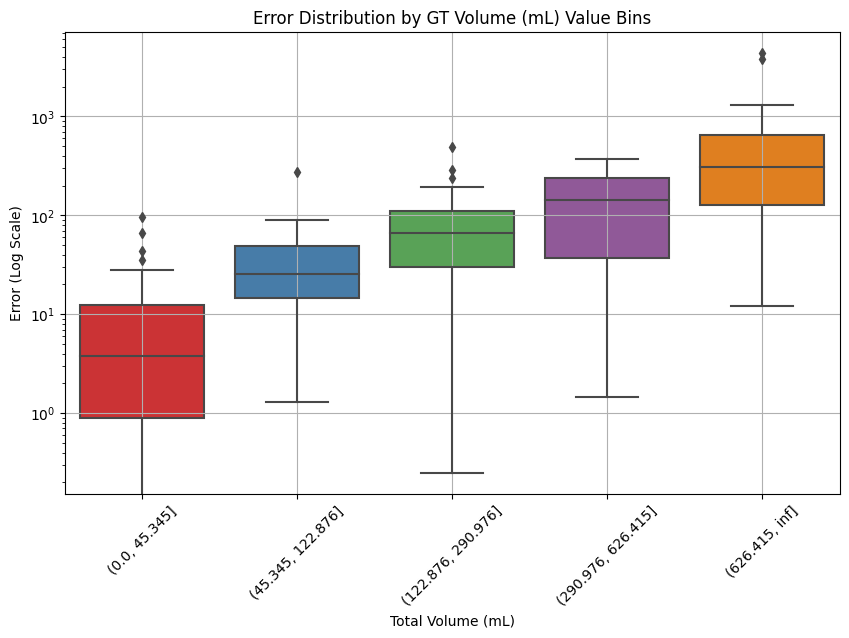

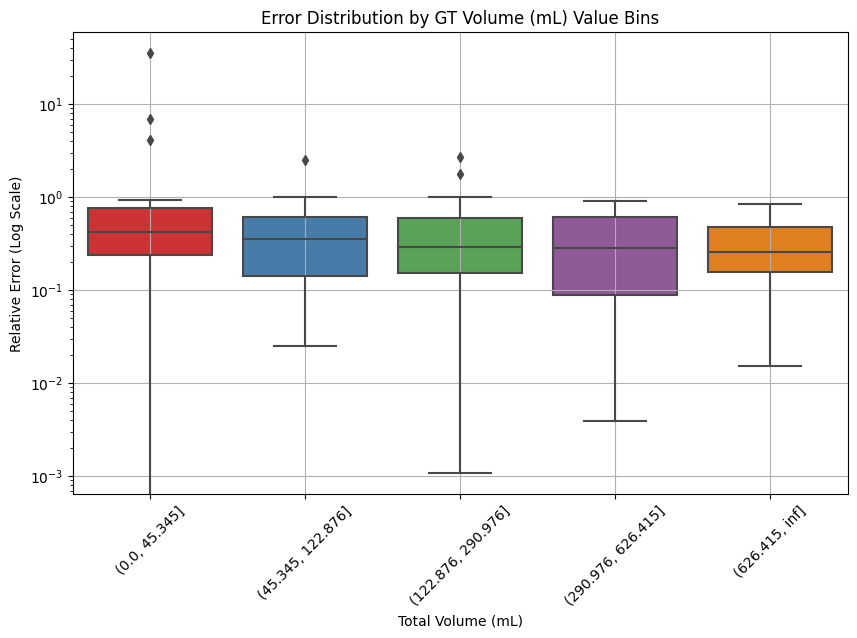

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all.xlsx'
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'#'TMTV_all_center_type_info.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate error
df['Error'] = abs((df['Predicted']/1000) - (df['GT']/1000))
df['Relative_Error'] = abs((df['Predicted'] - df['GT']) / df['GT'])

# Define the number of bins and bin edges for GT values
num_bins = 10  # You can adjust the number of bins as needed

# Create bins with merging after the 5th bin
volume_bins = pd.cut((df['GT']/1000), bins=[0, *(df['GT']/1000).quantile([0.2, 0.4, 0.6, 0.8]).values, float('inf')])

# Create a box plot using Seaborn with a logarithmic y-axis
plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='Error', data=df, palette='Set1')
plt.xlabel('Total Volume (mL)')
plt.ylabel('Error (Log Scale)')
plt.title('Error Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(True)
plt.show()


# Create a box plot using Seaborn with a logarithmic y-axis
plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='Relative_Error', data=df, palette='Set1')
plt.xlabel('Total Volume (mL)')
plt.ylabel('Relative Error (Log Scale)')
plt.title('Error Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(True)
plt.show()

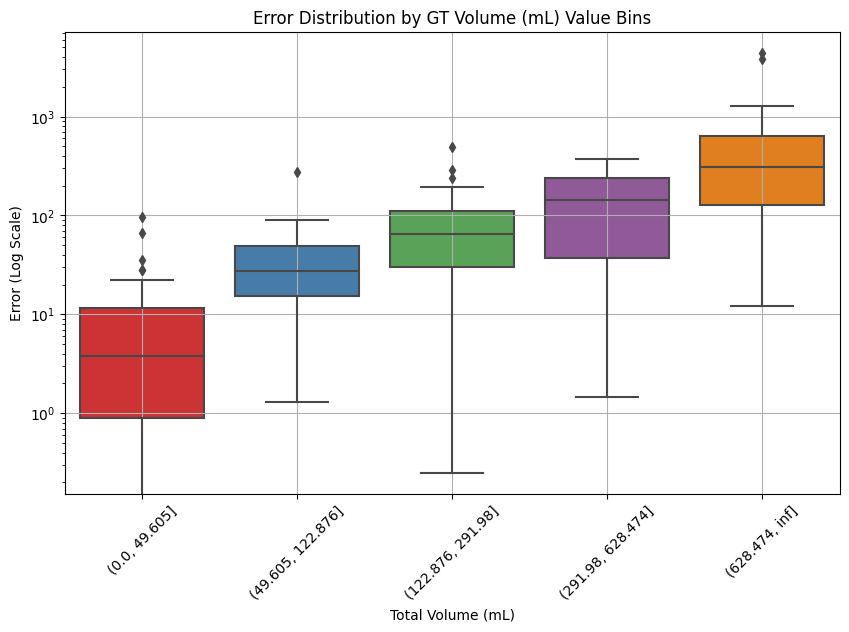

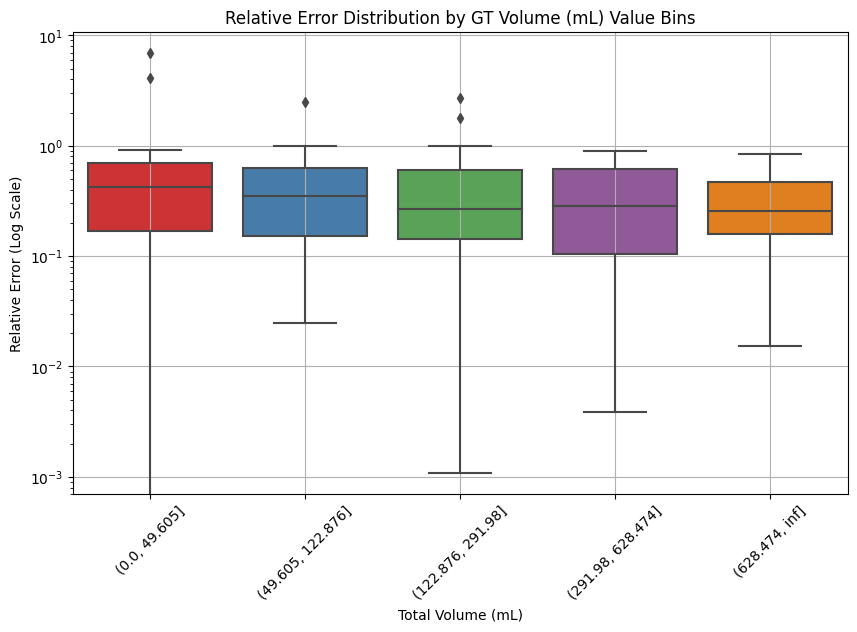

                  GT       Error             Relative_Error          
                            mean         std           mean       std
0      (0.0, 49.605]    8.864690   15.283771       0.590790  0.965170
1  (49.605, 122.876]   37.031941   38.442759       0.430111  0.382315
2  (122.876, 291.98]   84.484181   81.815994       0.418177  0.439448
3  (291.98, 628.474]  149.471582  114.666572       0.357385  0.269932
4     (628.474, inf]  504.790063  731.665287       0.331780  0.255972


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'
file_path = 'TMTV_all_center_type_info_no_outlier_324.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate error
df['Error'] = abs((df['Predicted'] / 1000) - (df['GT'] / 1000))
df['Relative_Error'] = abs((df['Predicted'] - df['GT']) / df['GT'])

# Define the number of bins and bin edges for GT values
num_bins = 10  # You can adjust the number of bins as needed

# Create bins with merging after the 5th bin
volume_bins = pd.cut((df['GT'] / 1000), bins=[0, *(df['GT'] / 1000).quantile([0.2, 0.4, 0.6, 0.8]).values, float('inf')])

# Calculate mean and std for Error and Relative_Error in each volume bin
mean_std_df = df.groupby(volume_bins).agg({'Error': ['mean', 'std'], 'Relative_Error': ['mean', 'std']}).reset_index()

# Create a box plot using Seaborn with a logarithmic y-axis
plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='Error', data=df, palette='Set1')
plt.xlabel('Total Volume (mL)')
plt.ylabel('Error (Log Scale)')
plt.title('Error Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(True)
plt.show()

# Create a box plot using Seaborn with a logarithmic y-axis
plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='Relative_Error', data=df, palette='Set1')
plt.xlabel('Total Volume (mL)')
plt.ylabel('Relative Error (Log Scale)')
plt.title('Relative Error Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(True)
plt.show()

# Display the mean and std values for Error and Relative_Error in each volume bin
print(mean_std_df)


In [ ]:
volume_bins

0      (290.976, 626.415]
1          (626.415, inf]
2          (626.415, inf]
3           (0.0, 45.345]
4      (122.876, 290.976]
              ...        
319         (0.0, 45.345]
320         (0.0, 45.345]
321         (0.0, 45.345]
322         (0.0, 45.345]
323         (0.0, 45.345]
Name: GT, Length: 324, dtype: category
Categories (5, interval[float64, right]): [(0.0, 45.345] < (45.345, 122.876] < (122.876, 290.976] <
                                           (290.976, 626.415] < (626.415, inf]]

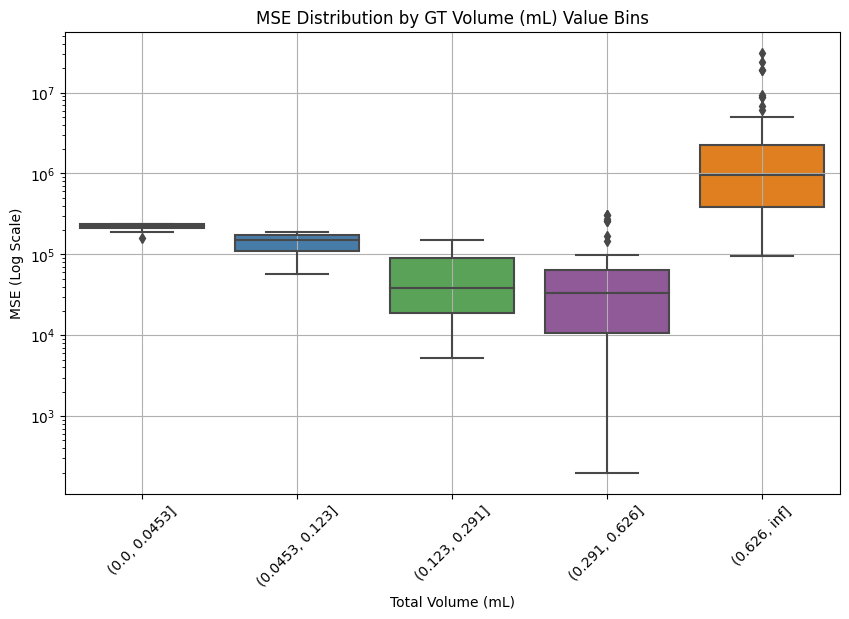

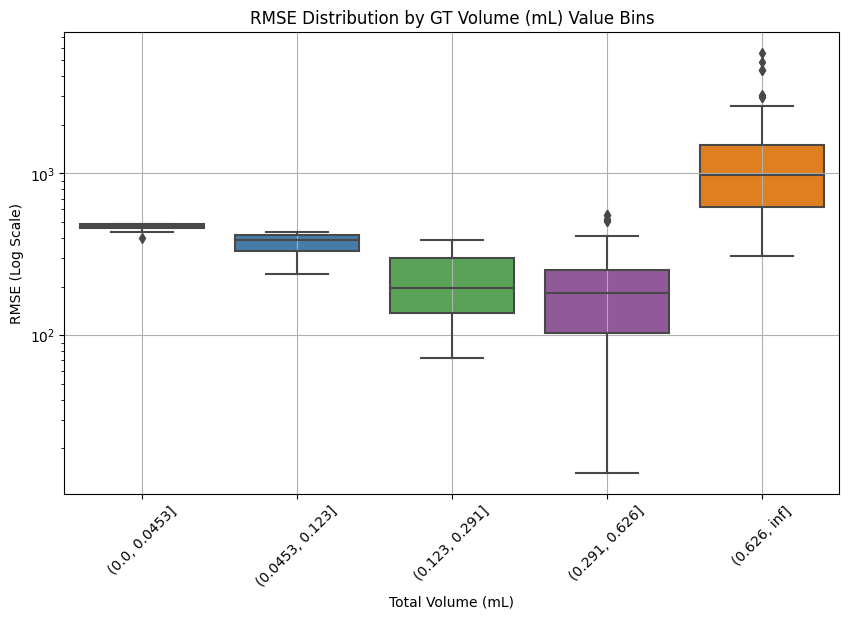

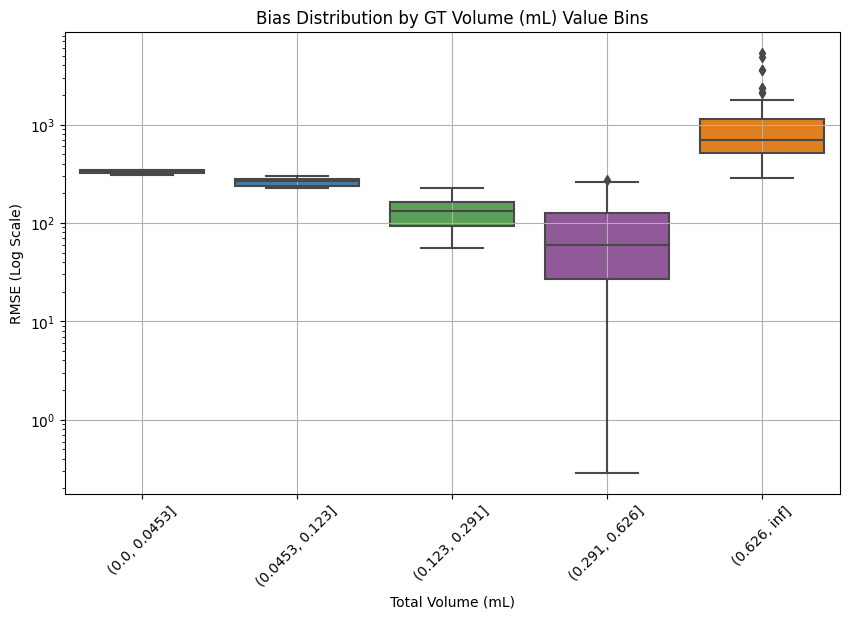

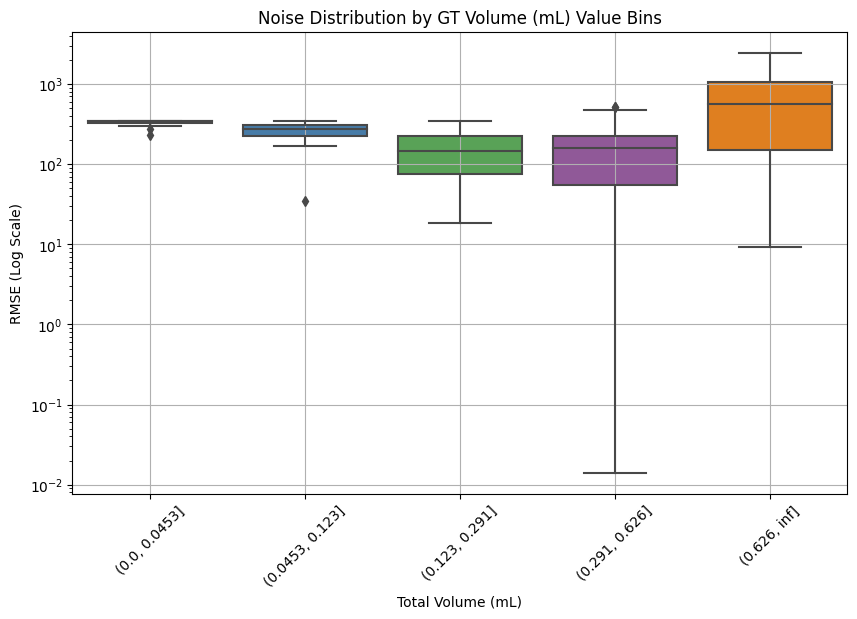

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all.xlsx'
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'#'TMTV_all_center_type_info.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)
df['Predicted']=df['Predicted']/1000
df['GT']=df['GT']/1000

mean_predicted = np.mean(df['Predicted'])
df['bias2']= ((mean_predicted - df['GT']) ** 2)

# Calculate Variance
df['variance'] = ((df['Predicted'] - mean_predicted) ** 2)
df['mse']=df['variance']+df['bias2']

df['rmse']=np.sqrt(df['mse'])
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Square Root of Bias and Variance
df['bias'] = np.sqrt(df['bias2'])
df['noise'] = np.sqrt(df['variance'])
# Calculate error
# df['Error'] = abs((df['Predicted']/1000) - (df['GT']/1000))
# df['Relative_Error'] = abs((df['Predicted'] - df['GT']) / df['GT'])



# Define the number of bins and bin edges for GT values
num_bins = 10  # You can adjust the number of bins as needed

# Create bins with merging after the 5th bin
volume_bins = pd.cut((df['GT']/1000), bins=[0, *(df['GT']/1000).quantile([0.2, 0.4, 0.6, 0.8]).values, float('inf')])

plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='mse', data=df, palette='Set1')
plt.xlabel('Total Volume (mL)')
plt.ylabel('MSE (Log Scale)')
plt.title('MSE Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(True)
plt.show()

# Create a box plot using Seaborn with a logarithmic y-axis
plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='rmse', data=df, palette='Set1')
plt.xlabel('Total Volume (mL)')
plt.ylabel('RMSE (Log Scale)')
plt.title('RMSE Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='bias', data=df, palette='Set1')
plt.xlabel('Total Volume (mL)')
plt.ylabel('RMSE (Log Scale)')
plt.title('Bias Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='noise', data=df, palette='Set1')
plt.xlabel('Total Volume (mL)')
plt.ylabel('RMSE (Log Scale)')
plt.title('Noise Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(True)
plt.show()


49.9359396415683
48.79533478714304
36.931121869712044
23.51967434355327
70.09585635198297


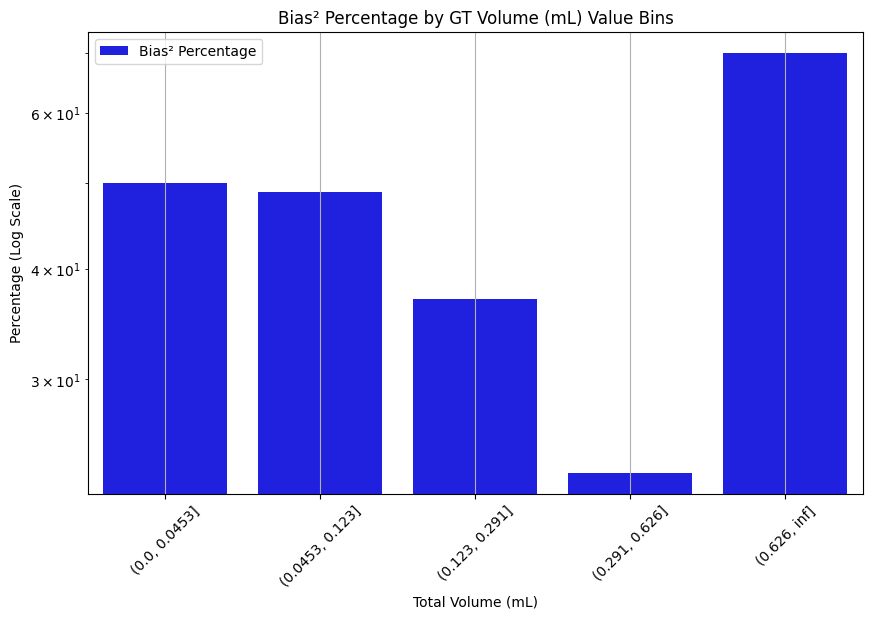

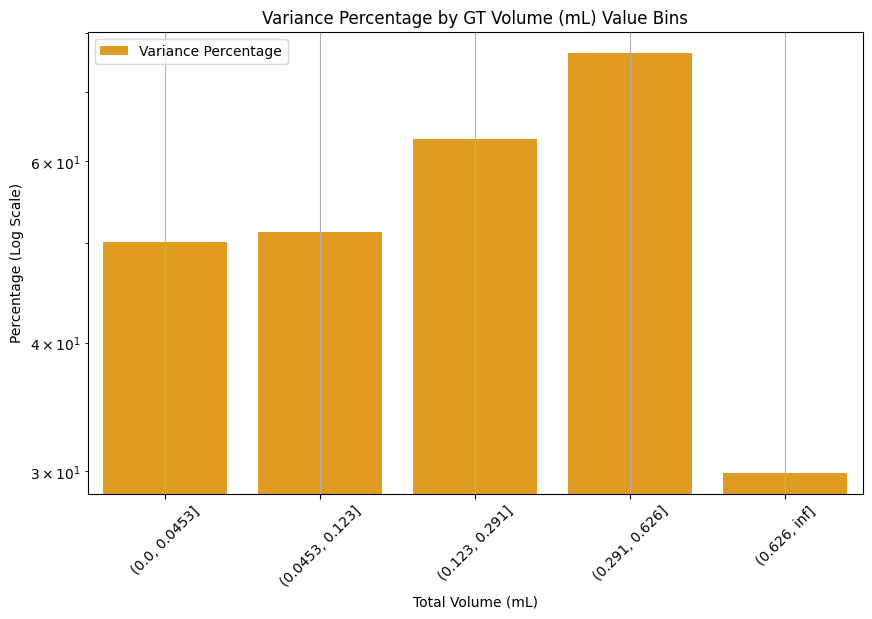

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)
df['Predicted'] = df['Predicted'] / 1000
df['GT'] = df['GT'] / 1000

mean_predicted = np.mean(df['Predicted'])
df['bias2'] = ((mean_predicted - df['GT']) ** 2)

# Calculate Variance
df['variance'] = ((df['Predicted'] - mean_predicted) ** 2)
df['mse'] = df['variance'] + df['bias2']

df['rmse'] = np.sqrt(df['mse'])

# Calculate Square Root of Bias and Variance
df['bias'] = np.sqrt(df['bias2'])
df['noise'] = np.sqrt(df['variance'])

# Define the number of bins and bin edges for GT values
num_bins = 10  # You can adjust the number of bins as needed

# Create bins with merging after the 5th bin
volume_bins = pd.cut((df['GT'] / 1000), bins=[0, *(df['GT'] / 1000).quantile([0.2, 0.4, 0.6, 0.8]).values, float('inf')])

# Calculate bias² and variance percentages for each bin
bias2_percentages = []
variance_percentages = []

for bin_label in volume_bins.cat.categories:
    bin_data = df[volume_bins == bin_label]
    total_samples = len(bin_data)
    bias2_percentage = (np.sum(bin_data['bias2']) / bin_data['mse'].sum()) * 100
    print(bias2_percentage)
    variance_percentage = (np.sum(bin_data['variance']) / bin_data['mse'].sum()) * 100
    bias2_percentages.append(bias2_percentage)
    variance_percentages.append(variance_percentage)

# Create a DataFrame for percentages
percentage_df = pd.DataFrame({
    'Volume Bin': volume_bins.cat.categories,
    'Bias² Percentage': bias2_percentages,
    'Variance Percentage': variance_percentages
})

# Create a bar plot with a logarithmic y-axis for bias² and variance percentages
plt.figure(figsize=(10, 6))
sns.barplot(x='Volume Bin', y='Bias² Percentage', data=percentage_df, color='blue', label='Bias² Percentage')
#sns.barplot(x='Volume Bin', y='Variance Percentage', data=percentage_df, color='orange', label='Variance Percentage')
plt.xlabel('Total Volume (mL)')
plt.ylabel('Percentage (Log Scale)')  # Set y-axis label
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.title('Bias² Percentage by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize=(10, 6))
#sns.barplot(x='Volume Bin', y='Bias² Percentage', data=percentage_df, color='blue', label='Bias² Percentage')
sns.barplot(x='Volume Bin', y='Variance Percentage', data=percentage_df, color='orange', label='Variance Percentage')
plt.xlabel('Total Volume (mL)')
plt.ylabel('Percentage (Log Scale)')  # Set y-axis label
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.title('Variance Percentage by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'
file_path = 'TMTV_all_center_type_info_no_outlier_324.xlsx'
# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)
df['Predicted'] = df['Predicted'] / 1000
df['GT'] = df['GT'] / 1000

mean_predicted = np.mean(df['Predicted'])
df['bias2'] = ((mean_predicted - df['GT']) ** 2)

# Calculate Variance
df['variance'] = ((df['Predicted'] - mean_predicted) ** 2)
df['mse'] = df['variance'] + df['bias2']

df['rmse'] = np.sqrt(df['mse'])

# Calculate Square Root of Bias and Variance
df['bias'] = np.sqrt(df['bias2'])
df['noise'] = np.sqrt(df['variance'])

# Define the number of bins and bin edges for GT values
num_bins = 10  # You can adjust the number of bins as needed

# Create bins with merging after the 5th bin
volume_bins = pd.cut((df['GT'] / 1000), bins=[0, *(df['GT'] / 1000).quantile([0.2, 0.4, 0.6, 0.8]).values, float('inf')])

# Create a DataFrame to store bias and noise values for each bin
bias_noise_df = pd.DataFrame()

# Calculate bias and noise for each bin
for bin_label in volume_bins.cat.categories:
    bin_data = df[volume_bins == bin_label]
    bias_mean = bin_data['bias'].mean()
    noise_mean = bin_data['noise'].mean()
    bias_noise_df = bias_noise_df.append({'Volume Bin': bin_label, 'Bias Mean': bias_mean, 'Noise Mean': noise_mean}, ignore_index=True)

# Print the bias and noise table
print(bias_noise_df)


        Volume Bin    Bias Mean  Noise Mean
0    (0.0, 0.0496]   332.587997  333.223025
1  (0.0496, 0.123]   262.581106  264.256043
2   (0.123, 0.292]   133.042017  155.126310
3   (0.292, 0.628]    87.311019  164.318119
4     (0.628, inf]  1065.214982  715.899264


<ipython-input-36-deecfe54089e>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_noise_df = bias_noise_df.append({'Volume Bin': bin_label, 'Bias Mean': bias_mean, 'Noise Mean': noise_mean}, ignore_index=True)
<ipython-input-36-deecfe54089e>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_noise_df = bias_noise_df.append({'Volume Bin': bin_label, 'Bias Mean': bias_mean, 'Noise Mean': noise_mean}, ignore_index=True)
<ipython-input-36-deecfe54089e>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_noise_df = bias_noise_df.append({'Volume Bin': bin_label, 'Bias Mean': bias_mean, 'Noise Mean': noise_mean}, ignore_index=True)
<ipython-input-36-deecfe54089e>:41: FutureWarning: The frame.append method is deprecated

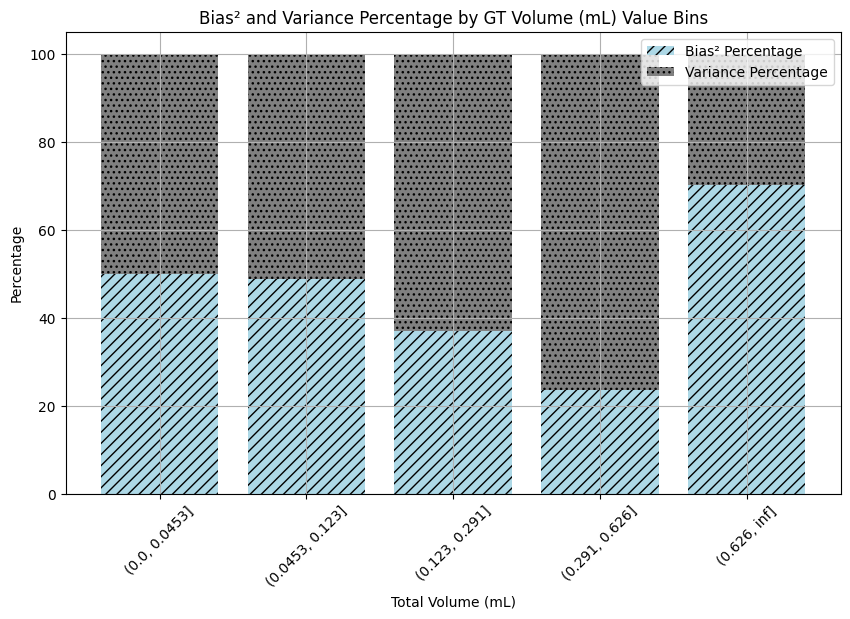

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)
df['Predicted'] = df['Predicted'] / 1000
df['GT'] = df['GT'] / 1000

mean_predicted = np.mean(df['Predicted'])
df['bias2'] = ((mean_predicted - df['GT']) ** 2)

# Calculate Variance
df['variance'] = ((df['Predicted'] - mean_predicted) ** 2)
df['mse'] = df['variance'] + df['bias2']

df['rmse'] = np.sqrt(df['mse'])

# Calculate Square Root of Bias and Variance
df['bias'] = np.sqrt(df['bias2'])
df['noise'] = np.sqrt(df['variance'])

# Define the number of bins and bin edges for GT values
num_bins = 10  # You can adjust the number of bins as needed

# Create bins with merging after the 5th bin
volume_bins = pd.cut((df['GT'] / 1000), bins=[0, *(df['GT'] / 1000).quantile([0.2, 0.4, 0.6, 0.8]).values, float('inf')])

# Calculate bias² and variance percentages for each bin
bias2_percentages = []
variance_percentages = []

for bin_label in volume_bins.cat.categories:
    bin_data = df[volume_bins == bin_label]
    total_samples = len(bin_data)
    bias2_percentage = (np.sum(bin_data['bias2']) / bin_data['mse'].sum()) * 100
    variance_percentage = (np.sum(bin_data['variance']) / bin_data['mse'].sum()) * 100
    bias2_percentages.append(bias2_percentage)
    variance_percentages.append(variance_percentage)

# Create a DataFrame for percentages
percentage_df = pd.DataFrame({
    'Volume Bin': volume_bins.cat.categories.astype(str),  # Convert intervals to strings
    'Bias² Percentage': bias2_percentages,
    'Variance Percentage': variance_percentages
})

# Create a stacked bar plot for Bias² and Variance percentages as complementary components of MSE
plt.figure(figsize=(10, 6))
plt.bar(percentage_df['Volume Bin'], percentage_df['Bias² Percentage'], color='lightblue', hatch='///', label='Bias² Percentage')
plt.bar(percentage_df['Volume Bin'], percentage_df['Variance Percentage'], bottom=percentage_df['Bias² Percentage'], color='grey', hatch='...', label='Variance Percentage')
plt.xlabel('Total Volume (mL)')
plt.ylabel('Percentage')  # Set y-axis label
plt.title('Bias² and Variance Percentage by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)

plt.legend()
plt.grid(True)

plt.show()



In [ ]:
percentage_df

,Volume Bin,Bias² Percentage,Variance Percentage
0,"(0.0, 0.0453]",49.935940,50.064060
1,"(0.0453, 0.123]",48.795335,51.204665
2,"(0.123, 0.291]",36.931122,63.068878
3,"(0.291, 0.626]",23.519674,76.480326
4,"(0.626, inf]",70.095856,29.904144


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)
df['Predicted'] = df['Predicted'] / 1000
df['GT'] = df['GT'] / 1000

mean_predicted = np.mean(df['Predicted'])
df['bias2'] = ((mean_predicted - df['GT']) ** 2)

# Calculate Variance
df['variance'] = ((df['Predicted'] - mean_predicted) ** 2)
df['mse'] = df['variance'] + df['bias2']

df['rmse'] = np.sqrt(df['mse'])

# Calculate Square Root of Bias and Variance
df['bias'] = np.sqrt(df['bias2'])
df['noise'] = np.sqrt(df['variance'])

# Define the number of bins and bin edges for GT values
num_bins = 10  # You can adjust the number of bins as needed

# Create bins with merging after the 5th bin
volume_bins = pd.cut((df['GT'] / 1000), bins=[0, *(df['GT'] / 1000).quantile([0.2, 0.4, 0.6, 0.8]).values, float('inf')])

# Calculate mean MSE and RMSE for each bin
mse_means = []
rmse_means = []

for bin_label in volume_bins.cat.categories:
    bin_data = df[volume_bins == bin_label]
    mse_mean = bin_data['mse'].mean()
    rmse_mean = bin_data['rmse'].mean()
    mse_means.append(mse_mean)
    rmse_means.append(rmse_mean)

# Create a DataFrame for mean MSE and RMSE
mean_error_df = pd.DataFrame({
    'Volume Bin': volume_bins.cat.categories.astype(str),
    'Mean MSE': mse_means,
    'Mean RMSE': rmse_means
})

# Print the table of mean MSE and RMSE
print(mean_error_df)


        Volume Bin      Mean MSE    Mean RMSE
0    (0.0, 0.0453]  2.215316e+05   470.292794
1  (0.0453, 0.123]  1.419820e+05   373.792901
2   (0.123, 0.291]  5.433025e+04   212.840177
3   (0.291, 0.626]  5.623275e+04   196.260137
4     (0.626, inf]  3.035921e+06  1340.488436


error and relative error withoutgh log scale

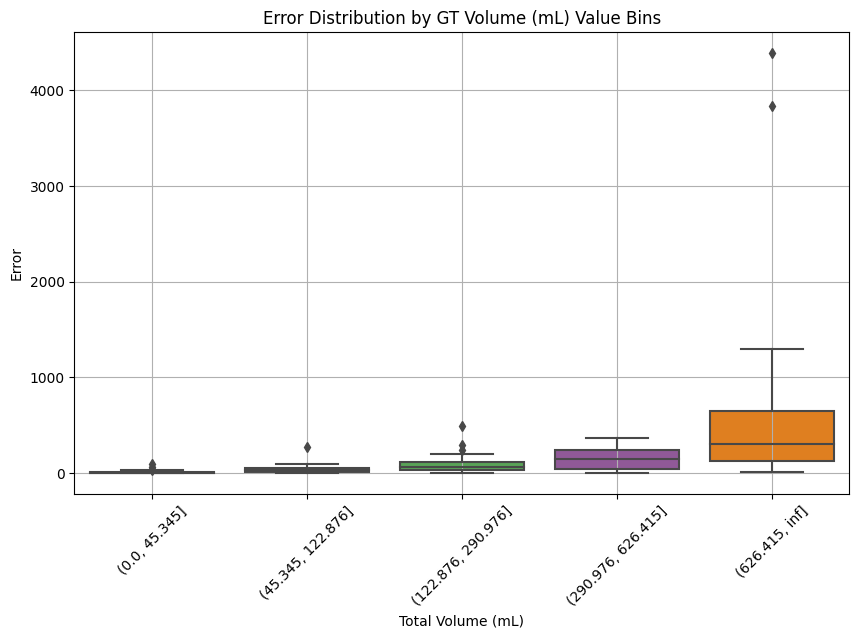

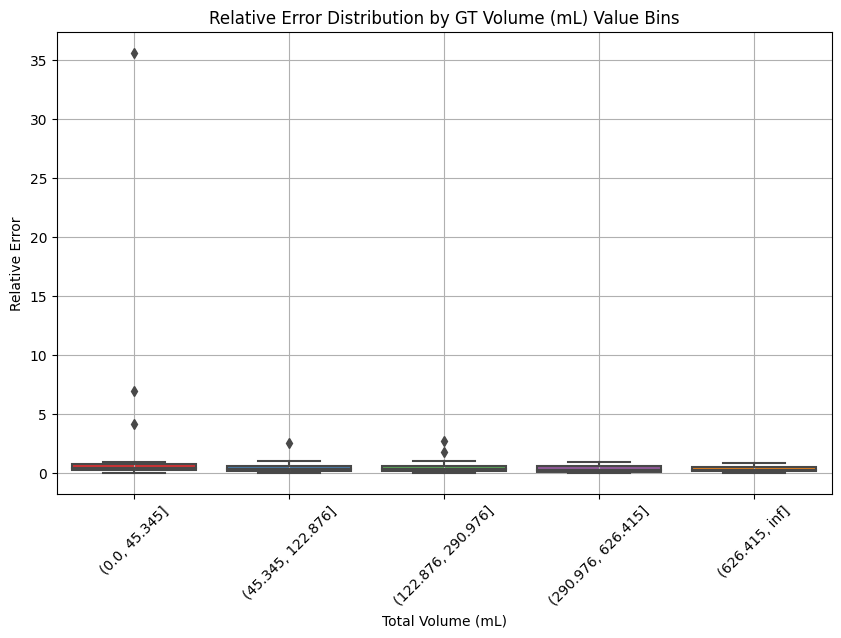

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate error
df['Error'] = abs((df['Predicted'] / 1000) - (df['GT'] / 1000))
df['Relative_Error'] = abs((df['Predicted'] - df['GT']) / df['GT'])

# Define the number of bins and bin edges for GT values
num_bins = 10  # You can adjust the number of bins as needed

# Create bins with merging after the 5th bin
volume_bins = pd.cut((df['GT'] / 1000), bins=[0, *(df['GT'] / 1000).quantile([0.2, 0.4, 0.6, 0.8]).values, float('inf')])

# Create a box plot using Seaborn with linear y-axis
plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='Error', data=df, palette='Set1')
plt.xlabel('Total Volume (mL)')
plt.ylabel('Error')
plt.title('Error Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Create a box plot using Seaborn with linear y-axis
plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='Relative_Error', data=df, palette='Set1')
plt.xlabel('Total Volume (mL)')
plt.ylabel('Relative Error')
plt.title('Relative Error Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


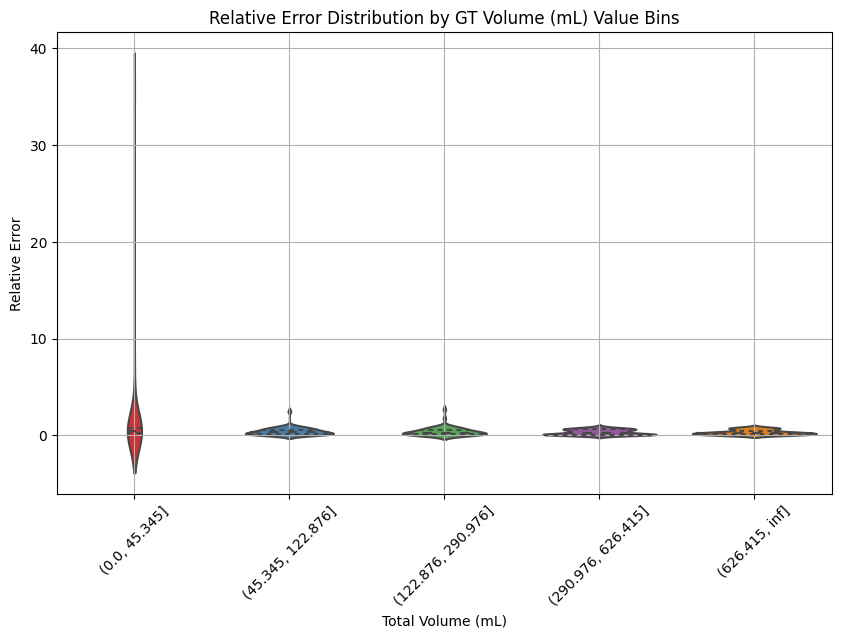

<ipython-input-11-d75b73721e0d>:32: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x=volume_bins, y='Relative_Error', data=df, palette='Set1', size=3)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 9.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


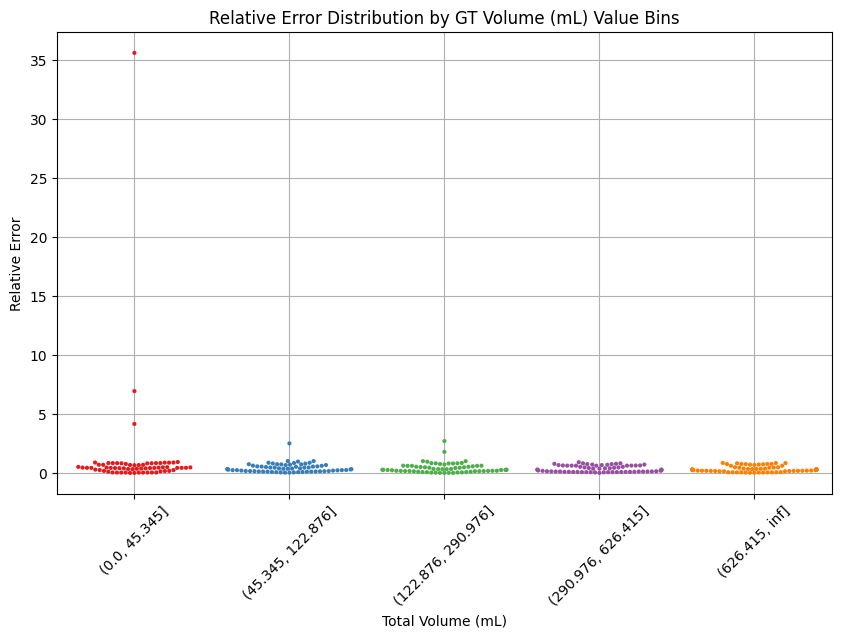

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate error
df['Relative_Error'] = abs((df['Predicted'] - df['GT']) / df['GT'])

# Define the number of bins and bin edges for GT values
num_bins = 10  # You can adjust the number of bins as needed

# Create bins with merging after the 5th bin
volume_bins = pd.cut((df['GT'] / 1000), bins=[0, *(df['GT'] / 1000).quantile([0.2, 0.4, 0.6, 0.8]).values, float('inf')])

# Create a violin plot for relative error
plt.figure(figsize=(10, 6))
sns.violinplot(x=volume_bins, y='Relative_Error', data=df, palette='Set1', inner="quart")
plt.xlabel('Total Volume (mL)')
plt.ylabel('Relative Error')
plt.title('Relative Error Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Create a swarm plot for relative error (use with caution if there are many data points)
plt.figure(figsize=(10, 6))
sns.swarmplot(x=volume_bins, y='Relative_Error', data=df, palette='Set1', size=3)
plt.xlabel('Total Volume (mL)')
plt.ylabel('Relative Error')
plt.title('Relative Error Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


error and relative error without abs

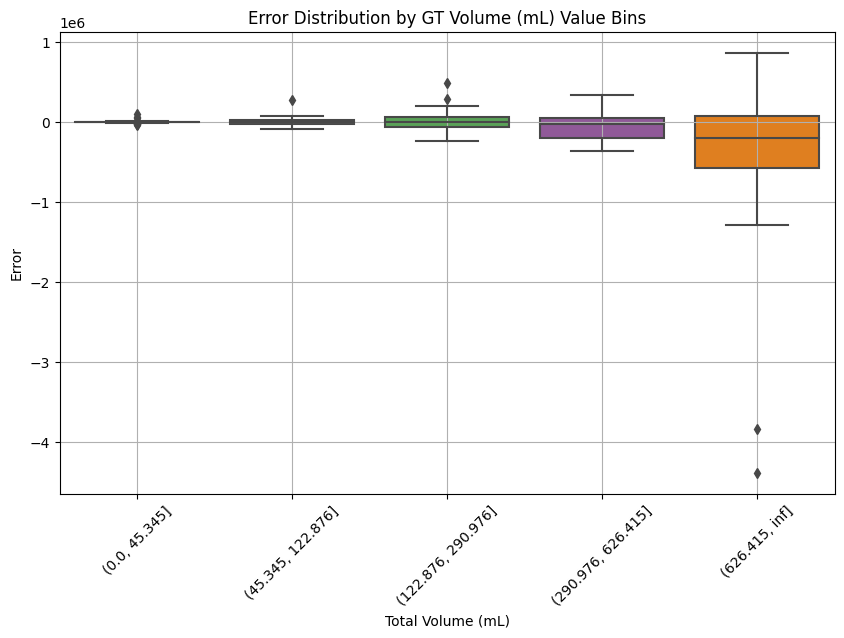

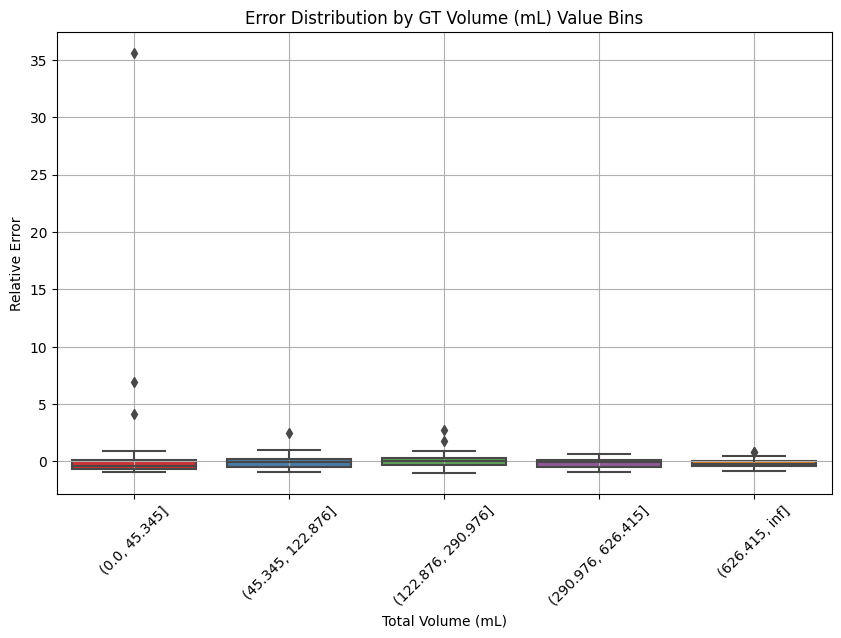

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all.xlsx'
file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'#'TMTV_all_center_type_info.xlsx'
#file_path = 'Noise_Bias_no_outlier_code.xlsx'
# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate error
df['Error'] = ((df['Predicted'] ) - (df['GT'] ))
df['Relative_Error'] = ((df['Predicted'] - df['GT']) / df['GT'])

# Define the number of bins and bin edges for GT values
num_bins = 10  # You can adjust the number of bins as needed

# Create bins with merging after the 5th bin
volume_bins = pd.cut((df['GT'] / 1000), bins=[0, *(df['GT'] / 1000).quantile([0.2, 0.4, 0.6, 0.8]).values, float('inf')])

# Create a box plot using Seaborn without a logarithmic y-axis
plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='Error', data=df, palette='Set1')
plt.xlabel('Total Volume (mL)')
plt.ylabel('Error')
plt.title('Error Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Create a box plot using Seaborn without a logarithmic y-axis
plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='Relative_Error', data=df, palette='Set1')
plt.xlabel('Total Volume (mL)')
plt.ylabel('Relative Error')
plt.title('Error Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


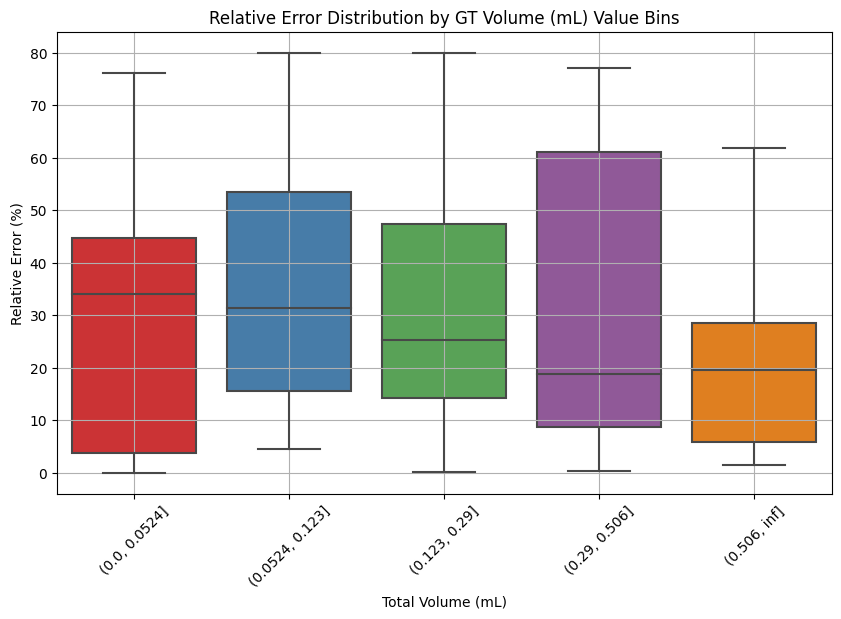

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all.xlsx'
#file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'#'TMTV_all_center_type_info.xlsx'
file_path = 'Noise_Bias_no_outlier_code.xlsx'
# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate relative error in percentage
df['Relative_Error_Percentage'] = abs((df['Predicted'] - df['GT']) / df['GT']) * 100

# Define the number of bins and bin edges for GT values
num_bins = 10  # You can adjust the number of bins as needed

# Create bins with merging after the 5th bin
volume_bins = pd.cut((df['GT']/1000), bins=[0, *(df['GT']/1000).quantile([0.2, 0.4, 0.6, 0.8]).values, float('inf')])

# Create a box plot using Seaborn with a linear y-axis (not logarithmic)
plt.figure(figsize=(10, 6))
sns.boxplot(x=volume_bins, y='Relative_Error_Percentage', data=df, palette='Set1')
plt.xlabel('Total Volume (mL)')
plt.ylabel('Relative Error (%)')  # Update the y-axis label
plt.title('Relative Error Distribution by GT Volume (mL) Value Bins')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df, *[[['Predicted', 'GT']]], **{})
chart

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all.xlsx'
file_path = 'TMTV_all_center_type_info.xlsx'
# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate relative error
df['Relative_Error'] = abs((df['Predicted'] - df['GT']) / df['GT'])

# Create a box plot using Seaborn for relative error grouped by data center
plt.figure(figsize=(10, 6))
sns.boxplot(x='data_center', y='Relative_Error', data=df, palette='viridis')
plt.xlabel('Data Center')
plt.ylabel('Relative Error')
plt.title('Relative Error by Data Center')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all.xlsx'
file_path = 'TMTV_all_center_type_info.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate relative error
df['Relative_Error'] = abs((df['Predicted'] - df['GT']) / df['GT'])

# Create a box plot using Seaborn for relative error grouped by data center
plt.figure(figsize=(10, 6))
sns.boxplot(x='data_center', y='Relative_Error', data=df, palette='viridis')
plt.xlabel('Data Center')
plt.ylabel('Relative Error (Log Scale)')
plt.title('Relative Error by Data Center (Log Scale)')
plt.xticks(rotation=45)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(True)
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = 'TMTV_all_center_type_info.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate relative error
df['Relative_Error'] = abs((df['Predicted'] - df['GT']) / df['GT'])

# Create a box plot using Seaborn for relative error grouped by data center
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='data_center', y='Relative_Error', data=df, palette='viridis')
plt.xlabel('Data Center')
plt.ylabel('Relative Error (Log Scale)')
plt.title('Relative Error by Data Center (Log Scale)')
plt.xticks(rotation=45)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(True)

# Add annotations with the count of data points in each category
for i, box in enumerate(ax.artists):
    num_data_points = len(df[df['data_center'] == ax.get_xticklabels()[i].get_text()])
    ax.annotate(f'N={num_data_points}', (box.get_x() + box.get_width() / 2, 0),
                xytext=(0, -10), textcoords='offset points',
                fontsize=10, ha='center', color='black')

plt.show()

# Create a box plot using Seaborn for relative error grouped by lymphoma type
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='lymphoma_type', y='Relative_Error', data=df, palette='viridis')
plt.xlabel('Lymphoma Type')
plt.ylabel('Relative Error (Log Scale)')
plt.title('Relative Error by Lymphoma Type (Log Scale)')
plt.xticks(rotation=45)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.grid(True)

# Add annotations with the count of data points in each category
for i, box in enumerate(ax.artists):
    num_data_points = len(df[df['lymphoma_type'] == ax.get_xticklabels()[i].get_text()])
    ax.annotate(f'N={num_data_points}', (box.get_x() + box.get_width() / 2, 0),
                xytext=(0, -10), textcoords='offset points',
                fontsize=10, ha='center', color='black')

plt.show()


<ipython-input-12-84b14e554481>:54: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax3 = sns.scatterplot(x='GT', y='error', data=df, palette='muted')


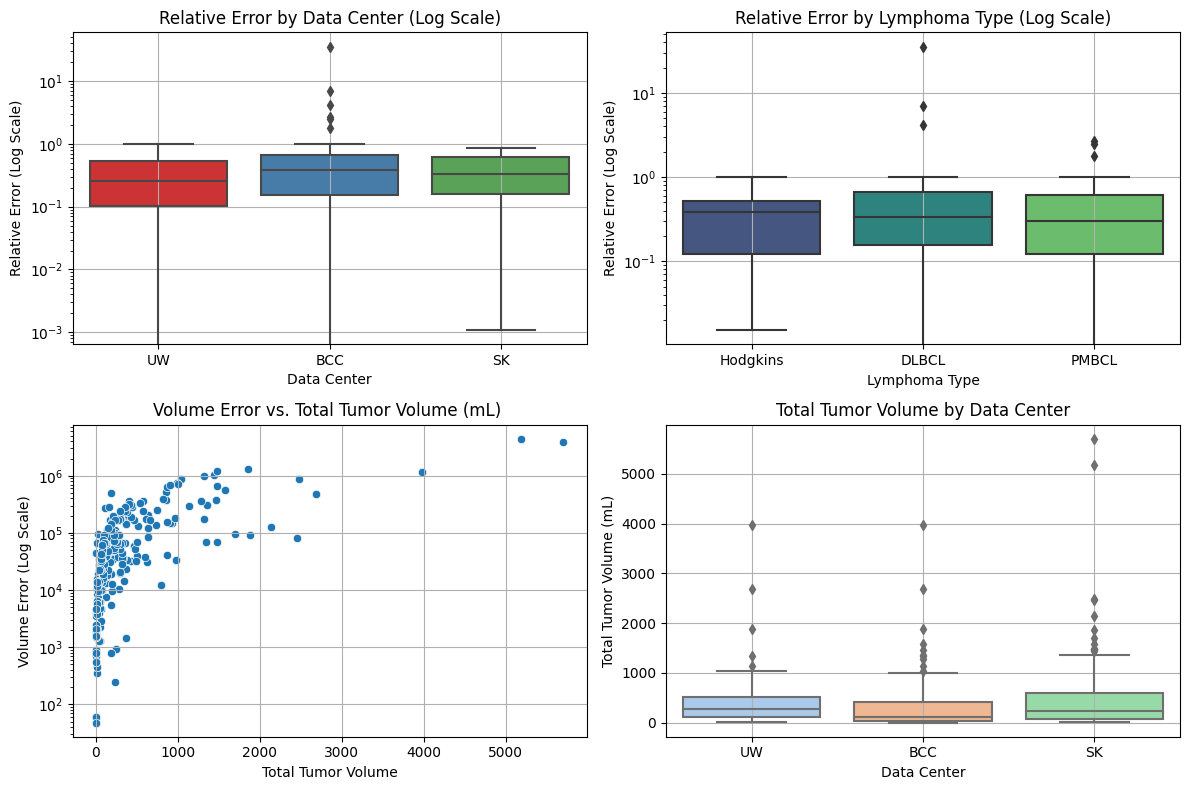

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all_center_type_info.xlsx'
file_path = 'TMTV_all_center_type_info_no_outlier_variance_noise.xlsx'#'TMTV_all_center_type_info_no_outlier.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Divide the 'GT' and 'Predicted' values by 1000
df['GT'] = df['GT'] / 1000
df['Predicted'] = df['Predicted'] / 1000

# Calculate relative error
df['Relative_Error'] = abs((df['Predicted'] - df['GT']) / df['GT'])

# Create a box plot using Seaborn for relative error grouped by data center
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)  # Create a 2x2 grid of plots, position 1
ax1 = sns.boxplot(x='data_center', y='Relative_Error', data=df, palette='Set1')#variance
ax1.set_xlabel('Data Center')
ax1.set_ylabel('Relative Error (Log Scale)')
ax1.set_title('Relative Error by Data Center (Log Scale)')
ax1.set_yscale('log')  # Set the y-axis to a logarithmic scale
ax1.grid(True)

# Add annotations with the count of data points in each category
for i, box in enumerate(ax1.artists):
    num_data_points = len(df[df['data_center'] == ax1.get_xticklabels()[i].get_text()])
    ax1.annotate(f'N={num_data_points}', (box.get_x() + box.get_width() / 2, 0),
                xytext=(0, -10), textcoords='offset points',
                fontsize=10, ha='center', color='black')

# Create a box plot using Seaborn for relative error grouped by lymphoma type
plt.subplot(2, 2, 2)  # Position 2
ax2 = sns.boxplot(x='lymphoma_type', y='Relative_Error', data=df, palette='viridis')
ax2.set_xlabel('Lymphoma Type')
ax2.set_ylabel('Relative Error (Log Scale)')
ax2.set_title('Relative Error by Lymphoma Type (Log Scale)')
ax2.set_yscale('log')  # Set the y-axis to a logarithmic scale
ax2.grid(True)

# Add annotations with the count of data points in each category
for i, box in enumerate(ax2.artists):
    num_data_points = len(df[df['lymphoma_type'] == ax2.get_xticklabels()[i].get_text()])
    ax2.annotate(f'N={num_data_points}', (box.get_x() + box.get_width() / 2, 0),
                xytext=(0, -10), textcoords='offset points',
                fontsize=10, ha='center', color='black')

# Create a scatterplot of Relative_Error versus GT (Tumor Size)
plt.subplot(2, 2, 3)  # Position 3
ax3 = sns.scatterplot(x='GT', y='error', data=df, palette='muted')
ax3.set_xlabel('Total Tumor Volume')
ax3.set_ylabel('Volume Error (Log Scale)')
ax3.set_title('Volume Error vs. Total Tumor Volume (mL) ')
ax3.set_yscale('log')  # Set the y-axis to a logarithmic scale
ax3.grid(True)

# Create a box plot of GT (Tumor Size) values grouped by data center
plt.subplot(2, 2, 4)  # Position 4
ax4 = sns.boxplot(x='data_center', y='GT', data=df, palette='pastel')
ax4.set_xlabel('Data Center')
ax4.set_ylabel('Total Tumor Volume (mL)')
ax4.set_title('Total Tumor Volume by Data Center')
ax4.grid(True)

plt.tight_layout()  # Adjust the layout to prevent overlapping plots
plt.show()


<ipython-input-18-631a3029eb5f>:52: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax3 = sns.scatterplot(x='GT', y='Relative_Error_Percentage', data=df, palette='muted')


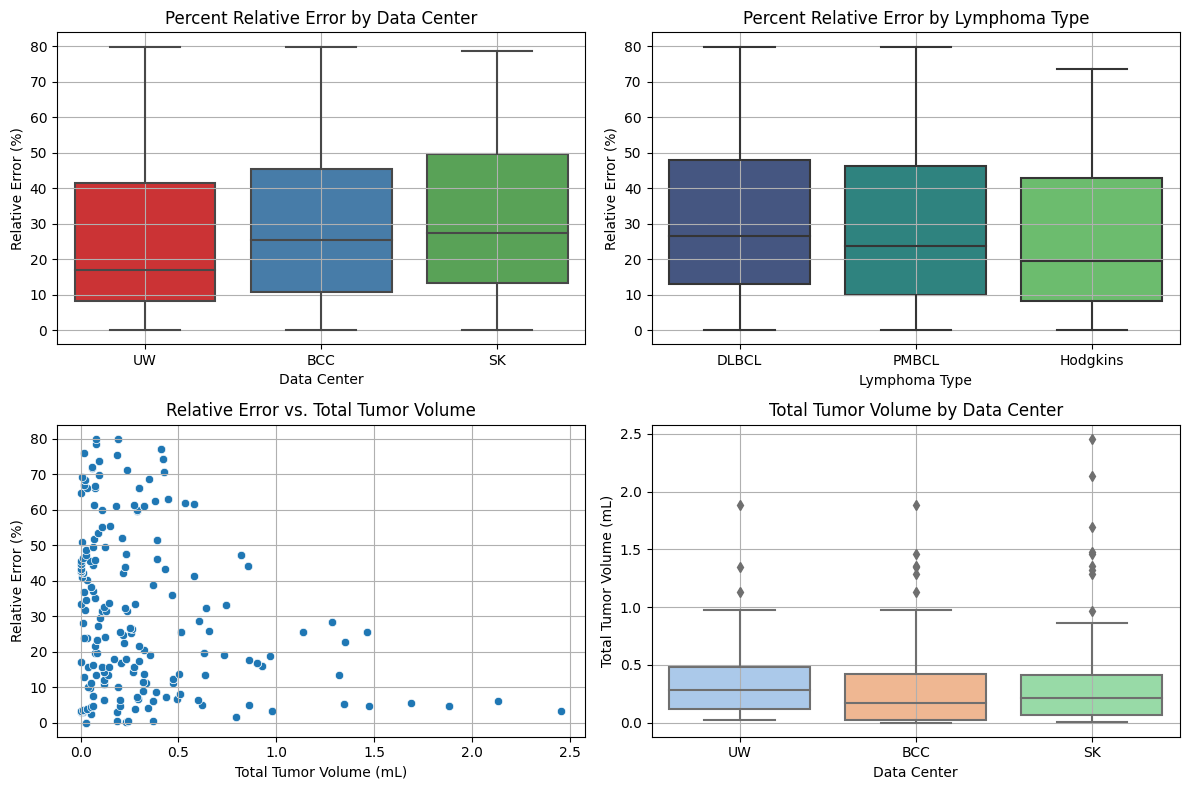

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
#file_path = 'TMTV_all_center_type_info.xlsx'
#file_path = 'TMTV_all_center_type_info_no_outlier_variance_noise.xlsx'#'TMTV_all_center_type_info_no_outlier.xlsx'
file_path = 'Noise_Bias_no_outlier_code.xlsx'
# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Divide the 'GT' and 'Predicted' values by 1000
df['GT'] = df['GT'] / 1000
df['Predicted'] = df['Predicted'] / 1000

# Calculate relative error in percentage
df['Relative_Error_Percentage'] = abs((df['Predicted'] - df['GT']) / df['GT']) * 100

# Create a box plot using Seaborn for relative error (in percentage) grouped by data center
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)  # Create a 2x2 grid of plots, position 1
ax1 = sns.boxplot(x='data_center', y='Relative_Error_Percentage', data=df, palette='Set1')
ax1.set_xlabel('Data Center')
ax1.set_ylabel('Relative Error (%)')  # Update the y-axis label
ax1.set_title('Percent Relative Error by Data Center')
ax1.grid(True)

# Add annotations with the count of data points in each category
for i, box in enumerate(ax1.artists):
    num_data_points = len(df[df['data_center'] == ax1.get_xticklabels()[i].get_text()])
    ax1.annotate(f'N={num_data_points}', (box.get_x() + box.get_width() / 2, 0),
                xytext=(0, -10), textcoords='offset points',
                fontsize=10, ha='center', color='black')

# Create a box plot using Seaborn for relative error (in percentage) grouped by lymphoma type
plt.subplot(2, 2, 2)  # Position 2
ax2 = sns.boxplot(x='lymphoma_type', y='Relative_Error_Percentage', data=df, palette='viridis')
ax2.set_xlabel('Lymphoma Type')
ax2.set_ylabel('Relative Error (%)')  # Update the y-axis label
ax2.set_title('Percent Relative Error by Lymphoma Type')
ax2.grid(True)

# Add annotations with the count of data points in each category
for i, box in enumerate(ax2.artists):
    num_data_points = len(df[df['lymphoma_type'] == ax2.get_xticklabels()[i].get_text()])
    ax2.annotate(f'N={num_data_points}', (box.get_x() + box.get_width() / 2, 0),
                xytext=(0, -10), textcoords='offset points',
                fontsize=10, ha='center', color='black')

# Create a scatterplot of Relative_Error_Percentage versus GT (Tumor Size)
plt.subplot(2, 2, 3)  # Position 3
ax3 = sns.scatterplot(x='GT', y='Relative_Error_Percentage', data=df, palette='muted')
ax3.set_xlabel('Total Tumor Volume (mL)')
ax3.set_ylabel('Relative Error (%)')  # Update the y-axis label
ax3.set_title('Relative Error vs. Total Tumor Volume')
ax3.grid(True)

# Create a box plot of GT (Tumor Size) values grouped by data center
plt.subplot(2, 2, 4)  # Position 4
ax4 = sns.boxplot(x='data_center', y='GT', data=df, palette='pastel')
ax4.set_xlabel('Data Center')
ax4.set_ylabel('Total Tumor Volume (mL)')
ax4.set_title('Total Tumor Volume by Data Center')
ax4.grid(True)

plt.tight_layout()  # Adjust the layout to prevent overlapping plots
plt.show()


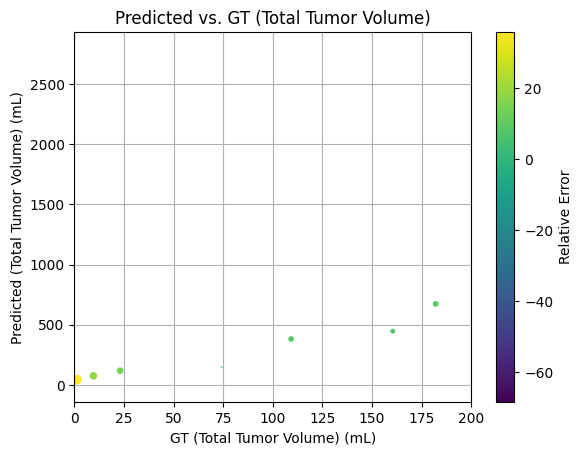

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Replace 'your_file_path' with the actual path to your Excel file on Google Drive
file_path = file_path = 'TMTV_all_center_type_info_no_outlier.xlsx'#'TMTV_all_center_type_info.xlsx'

# Read the data into a Pandas DataFrame
df = pd.read_excel(file_path)

# Calculate the point sizes based on the logarithm of the 'relative_error' column
point_size = np.log(df['relative_error']) * 10  # Adjust the scaling factor as needed

# Create a scatterplot of Predicted versus GT (Total Tumor Volume) with logarithmic point sizes


# Create a colormap for the 'size' column
cmap = plt.cm.get_cmap('viridis')

# Scatterplot with logarithmic point sizes and a colormap based on the 'size' column
scatter = plt.scatter(x=(df['GT']/1000), y=(df['Predicted']/1000), c=point_size, s=point_size, cmap=cmap)
plt.xlabel('GT (Total Tumor Volume) (mL)')
plt.ylabel('Predicted (Total Tumor Volume) (mL)')
plt.title('Predicted vs. GT (Total Tumor Volume)')
plt.xlim(0, 200)
# Add a colorbar for the 'size' column
cbar = plt.colorbar(scatter, label='Relative Error', orientation='vertical')
cbar.set_label('Relative Error')

plt.grid(True)
plt.show()


<Axes: xlabel='GT', ylabel='Predicted'>

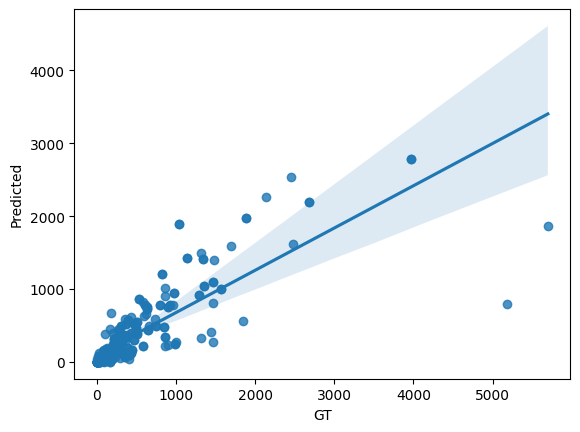

In [ ]:
x=(df['GT']/1000)
y=(df['Predicted']/1000)
sns.regplot(x = x, y = y)

In [ ]:
import numpy as np
from scipy.ndimage import label

# Threshold your predicted mask
threshold = 0.5  # Adjust this threshold as needed
predicted_mask = (predicted_mask > threshold).astype(np.int)

# Perform connected component analysis
connected_components, num_components = label(predicted_mask)

# Initialize counters for detected and undetected regions
detected_regions = 0
undetected_regions = 0

# Check each connected component
for label_id in range(1, num_components + 1):
    # Extract the region associated with this label
    region = (connected_components == label_id)

    # Check if at least one voxel is within the predicted mask
    if np.any(region & predicted_mask):
        detected_regions += 1
    else:
        undetected_regions += 1

# Calculate precision, recall, F1-score, etc. based on the above counts
# Calculate precision, recall, F1-score, etc. based on the above counts
precision = detected_regions / (detected_regions + undetected_regions)
recall = detected_regions / num_actual_regions  # You'll need to define num_actual_regions
f1_score = 2 * (precision * recall) / (precision + recall)

# You can also calculate other metrics like IoU if needed
intersection = np.sum(predicted_mask & ground_truth_mask)
union = np.sum(predicted_mask | ground_truth_mask)
iou = intersection / union



In [ ]:
import os
import glob
import SimpleITK as sitk
import numpy as np
import pandas as pd
from tqdm import tqdm

def calculate_dice_score(gt_image, pred_image):
    gt_arr = sitk.GetArrayFromImage(gt_image)
    pred_arr = sitk.GetArrayFromImage(pred_image)
    intersection = np.logical_and(gt_arr, pred_arr).sum()
    dice = (2.0 * intersection) / (gt_arr.sum() + pred_arr.sum())
    return dice

def calculate_metrics(gt_image, pred_image):
    gt_arr = sitk.GetArrayFromImage(gt_image)
    pred_arr = sitk.GetArrayFromImage(pred_image)

    true_positive = np.logical_and(gt_arr, pred_arr).sum()
    false_positive = np.logical_and(np.logical_not(gt_arr), pred_arr).sum()
    false_negative = np.logical_and(gt_arr, np.logical_not(pred_arr)).sum()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    # Calculate localization error and detection rate
    localization_error = (false_positive + false_negative) / (true_positive + false_positive + false_negative)
    detection_rate = true_positive / (true_positive + false_negative)

    return precision, recall, false_positive, false_negative, localization_error, detection_rate

results = []

input_path = 'DLBCL_outcome_prediction/Tyler_lymphoma'
output_dir = '/content/drive/MyDrive/TMTV_Dmax_EJNMMI/'
input_path = '/content/drive/MyDrive/' + input_path
case_ids = os.listdir(input_path)

for n, case_name in tqdm(enumerate(case_ids), total=len(case_ids)):
    path_img_nii = str(input_path) + "/" + str(case_name)
    pred_path = glob.glob(path_img_nii + "/" + str(case_name) + "_SEG.nii.gz")[0]
    gt_path = glob.glob(path_img_nii + "/" + str(case_name) + "_REF.nii.gz")[0]

    gt_image = sitk.ReadImage(gt_path)
    pred_image = sitk.ReadImage(pred_path)

    threshold = 12
    gt_image_arr = sitk.GetArrayFromImage(gt_image)
    gt_image_arr_new = np.where((gt_image_arr <= threshold) & (gt_image_arr != 0), 1, 0)

    gt_image_new = sitk.GetImageFromArray(gt_image_arr_new)
    gt_image_new.SetOrigin(gt_image.GetOrigin())
    gt_image_new.SetSpacing(gt_image.GetSpacing())
    gt_image_new.SetDirection(gt_image.GetDirection())

    dice = calculate_dice_score(gt_image_new, pred_image)
    precision, recall, false_positive, false_negative, localization_error, detection_rate = calculate_metrics(gt_image_new, pred_image)

    results.append({
        "PatientID": case_name,
        "Dice": dice,
        "Precision": precision,
        "Recall": recall,
        "FalsePositiveVolume": false_positive,
        "FalseNegativeVolume": false_negative,
        "LocalizationError": localization_error,
        "DetectionRate": detection_rate
    })

results_df = pd.DataFrame(results)
results_df.to_csv(output_dir + "performance_seg_det_12.csv", index=False)


 37%|███▋      | 29/79 [01:04<01:40,  2.02s/it]<ipython-input-40-8713985d2a8a>:22: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positive / (true_positive + false_positive)
 61%|██████    | 48/79 [01:36<00:50,  1.64s/it]<ipython-input-40-8713985d2a8a>:22: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positive / (true_positive + false_positive)
 66%|██████▌   | 52/79 [01:44<00:49,  1.85s/it]<ipython-input-40-8713985d2a8a>:22: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positive / (true_positive + false_positive)
 96%|█████████▌| 76/79 [02:28<00:05,  1.89s/it]<ipython-input-40-8713985d2a8a>:22: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_positive / (true_positive + false_positive)
100%|██████████| 79/79 [02:33<00:00,  1.95s/it]
